# Exploration of Feature Effects for Hyperparameter Optimization   

## Usage of PDP's in the Presence of a Sampling Bias

In [3]:
# -- Packages -- 

# data handling
library("data.table")
library("BBmisc")

# mlrMBO
library("mlrMBO")
library("mlr")

# iml methods
library("iml")

source("obj_functions.R")
source("plot_helpers.R")
source("mbo_helpers.R")

theme_set(theme_classic())

### Scenario 

Assume an optimizer generated a optimization trace $\mathcal{D} = \left((\lambda^{(1)}, c^{(1)}), (\lambda^{(2)}, c^{(2)}),..., (\lambda^{(n)}, c^{(n)})\right)$. We assume that this trace is generated by an optimization process, for which we assume that 

$$
(\lambda^{(i)}, c^{(i)}) \overset{i \to \infty}{\longrightarrow} (\hat \lambda, \hat c) 
$$

(or assume at least that there are finitely many accumulation points). 

Furthermore, assume that we fitted a Gaussian process $\hat f$ on this data. 

### Partial Dependence Plots

Partial dependence plots visualize the marginal distribution of $\lambda_S$, the feature we are interested in 

$$
    \hat f_{\lambda_S}(\lambda_S) = \mathbb{E}_{\lambda_C}\left[\hat f(\lambda)\right] = \int \hat f(\lambda_S, \lambda_C) p_{\lambda_C}(\lambda_C) ~\mathrm{d}\lambda_C, 
$$

with $p_{\lambda_S}$ being the marginal distribution of $\lambda_S$. 

This is usually approximated by 

$$
    \frac{1}{n}\sum_{i = 1}^n \hat f(x_S, x_C^{(i)}). 
$$

So for a grid point $x_S$, the features $x_C$ are replace by the values in the training data. 

### Partial Dependence Plots on "Training Data"

Note that applying partial dependence plots on the training data is not recommendable, since it is not going to show us the effect we would like to see. 

In [4]:
obj = binary_example_1
ps = getParamSet(obj)

grid = generateGridDesign(par.set = ps, resolution = 500)
grid$perf = unlist(lapply(dfRowsToList(grid, ps), obj))

grid = as.data.table(grid)

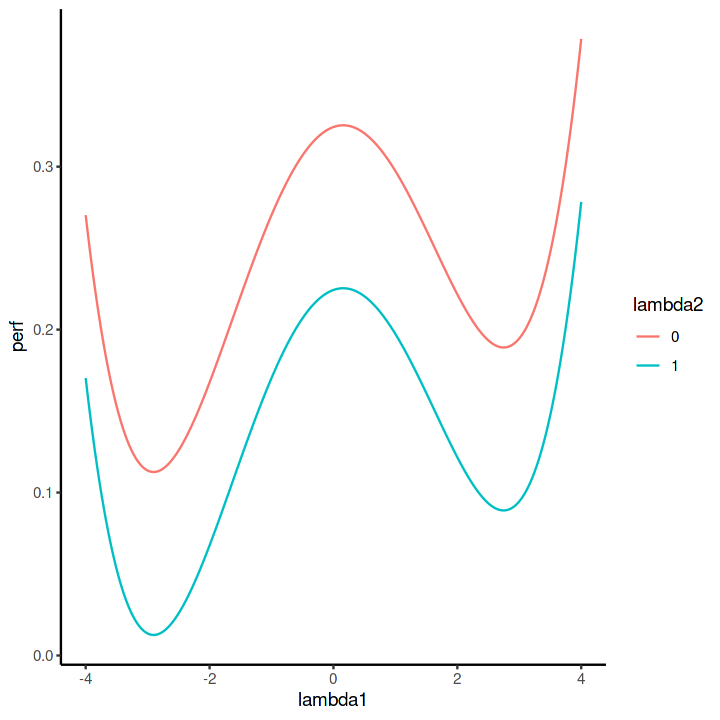

In [5]:
options(repr.plot.width=6, repr.plot.height=6)

gg = grid; gg$lambda2 = as.factor(gg$lambda2)
ggplot(data = gg, aes(x = lambda1, y = perf, colour = lambda2, group = lambda2)) + geom_line()

Per design, the effect of turning on the second configruation $\lambda_2 = 1$ results in an performance gain of $0.1$. A partial dependence plot should tell us exactly this! 

$gt


Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


$gt


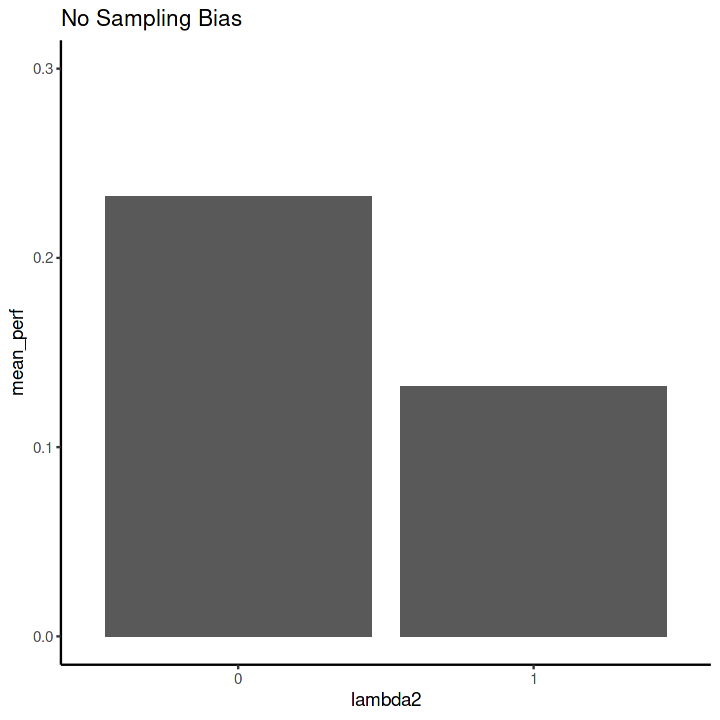

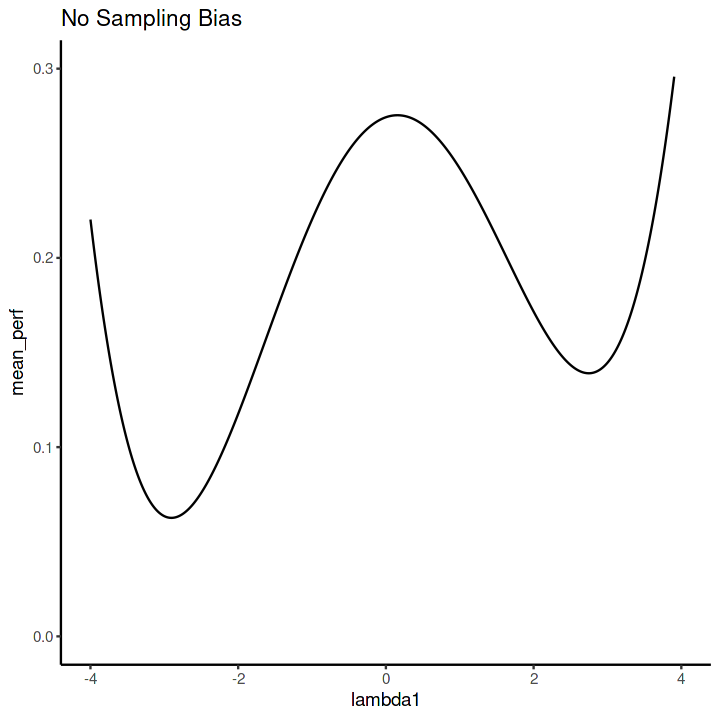

In [6]:

grid_sm = gg[, list(mean_perf = mean(perf), sd = sd(perf)), by = "lambda2"]

# p = ggplot(data = grid_sm, aes(x = lambda2, y = mean_perf, colour = lambda2)) + geom_point() # + geom_jitter(data = gg, aes(x = lambda2, y = perf), alpha = 0.2)
# p + geom_errorbar(aes(ymin = mean_perf - sd, ymax = mean_perf + sd)) + geom_hline(aes(yintercept = mean_perf, colour = lambda2))

# (p1 = ggplot(data = gg, aes(middle = mean(perf), y = perf, colour = lambda2)) + geom_boxplot())
p1 = ggplot(data = grid_sm, aes(y = mean_perf, x = lambda2)) + geom_bar(stat = "identity") + ggtitle("No Sampling Bias")
pl_lambda1 = list(gt = p1 + ylim(c(0, 0.3)))
pl_lambda1

grid_sm = gg[, list(mean_perf = mean(perf), sd = sd(perf)), by = "lambda1"]

p1 = ggplot(data = grid_sm, aes(x = lambda1, y = mean_perf)) + geom_line() + ggtitle("No Sampling Bias")
pl_lambda2 = list(gt = p1 + ylim(c(0, 0.3)))
pl_lambda2

In [7]:
# ! only run once
path = "notebook_data/binary_example_1_lambda_1.rds"
# createMBOrun(fun = obj, max.evals = 200, lambda = 1, store_path = "notebook_data/binary_example_1_lambda_1.rds", init_size = 8)

In [8]:
run = readRDS(path)
model = run$models; model = model[[length(model)]]
opdf = as.data.frame(run$opt.path)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



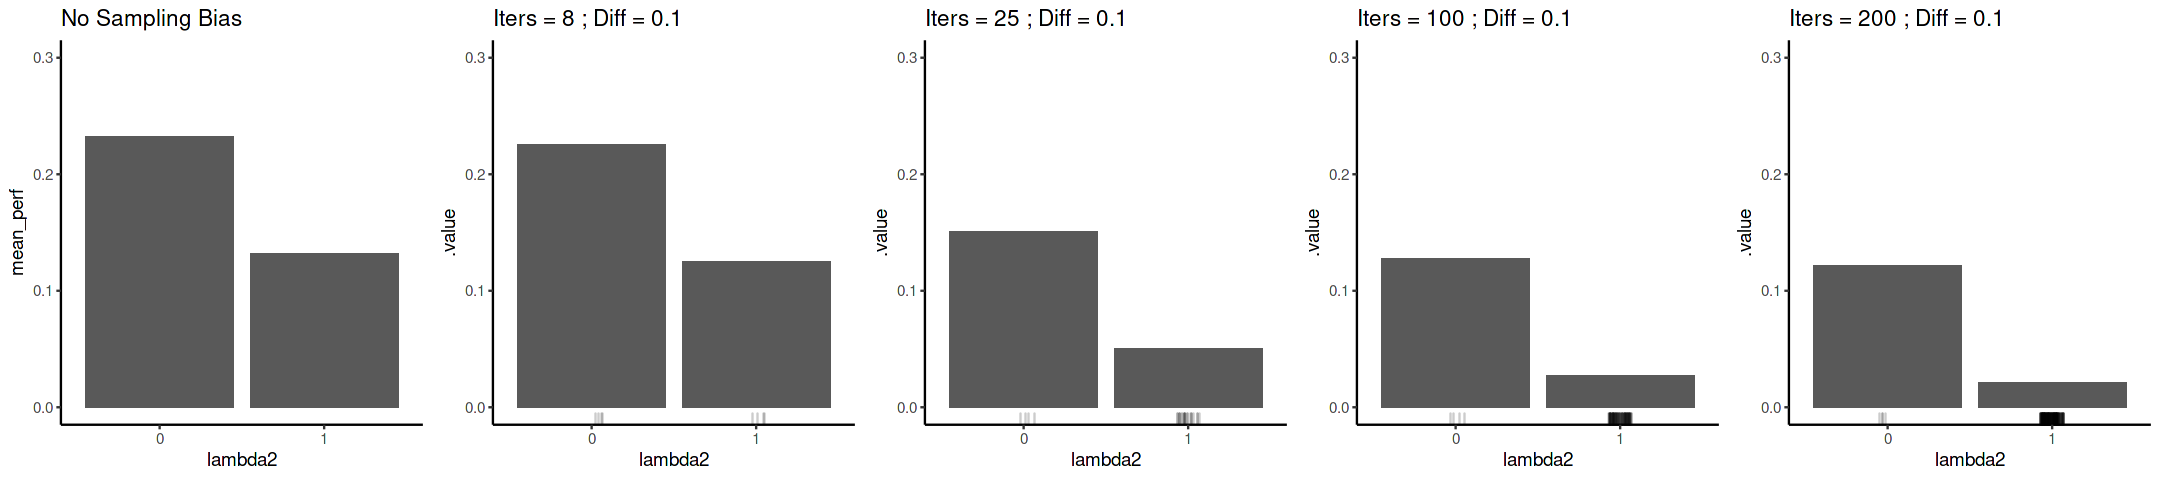

In [9]:
options(repr.plot.width=18, repr.plot.height=4)

for (i in c(8, 25, 100, 200)) {
    opdf_sub = opdf[seq_len(i), c("lambda1", "lambda2")]
    
    mymodel = makeS3Obj("mymodel", fun = function(data) return(unlist(lapply(dfRowsToList(data[, c("lambda1", "lambda2")], ps), obj))))
                        
    predict.mymodel = function(object, newdata) {
        object$fun(newdata)
    }
    
    predictor = Predictor$new(mymodel, data = opdf_sub, predict.function = predict.mymodel)
    effects = FeatureEffect$new(predictor = predictor, feature = "lambda2", method = "pdp")
    diff = effects$results$.value[2] - effects$results$.value[1]
    pl_lambda1[[paste("iter_", i, sep = "")]] = effects$plot() + ggtitle(paste("Iters =", i, "; Diff =", round(diff, 2))) + ylim(c(0, 0.3))
}
                        
do.call(grid.arrange, args = c(pl_lambda1, nrow = 1))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


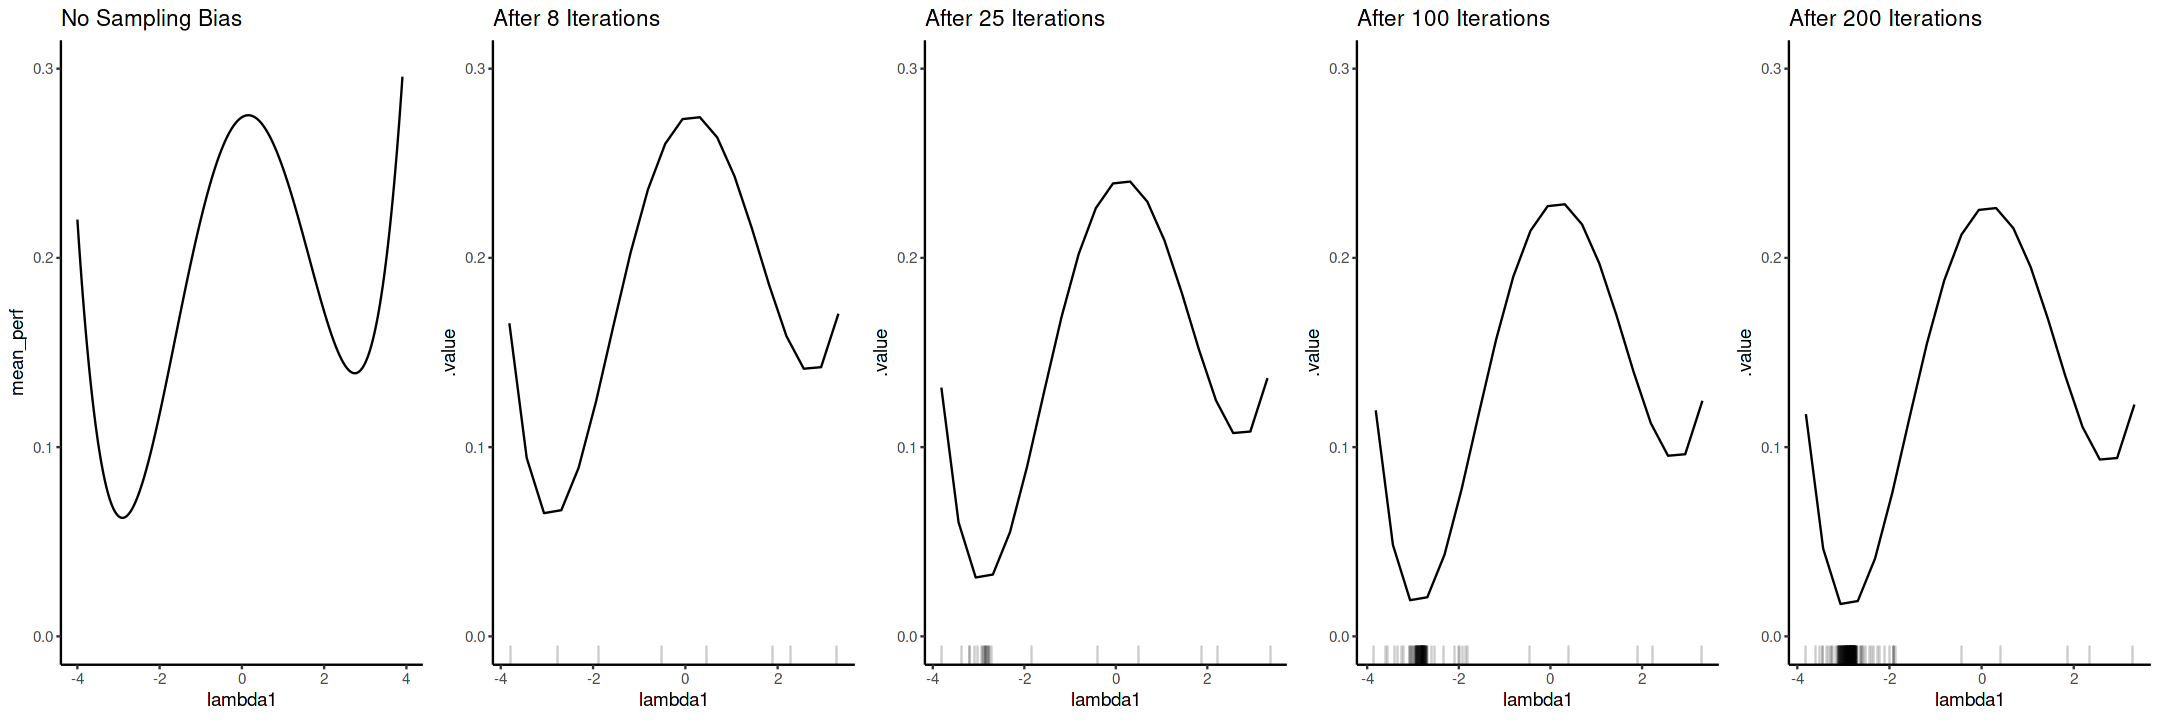

In [10]:
options(repr.plot.width=18, repr.plot.height=6)

for (i in c(8, 25, 100, 200)) {
    opdf_sub = opdf[seq_len(i), c("lambda1", "lambda2")]
    
    mymodel = makeS3Obj("mymodel", fun = function(data) return(unlist(lapply(dfRowsToList(data[, c("lambda1", "lambda2")], ps), obj))))
                        
    predict.mymodel = function(object, newdata) {
        object$fun(newdata)
    }
    
    predictor = Predictor$new(mymodel, data = opdf_sub, predict.function = predict.mymodel)
    effects = FeatureEffect$new(predictor = predictor, feature = "lambda1", method = "pdp")
    pl_lambda2[[paste("iter_", i, sep = "")]] = effects$plot() + ggtitle(paste("After", i, "Iterations")) + ylim(c(0, 0.3))
}
                        
do.call(grid.arrange, args = c(pl_lambda2, nrow = 1))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



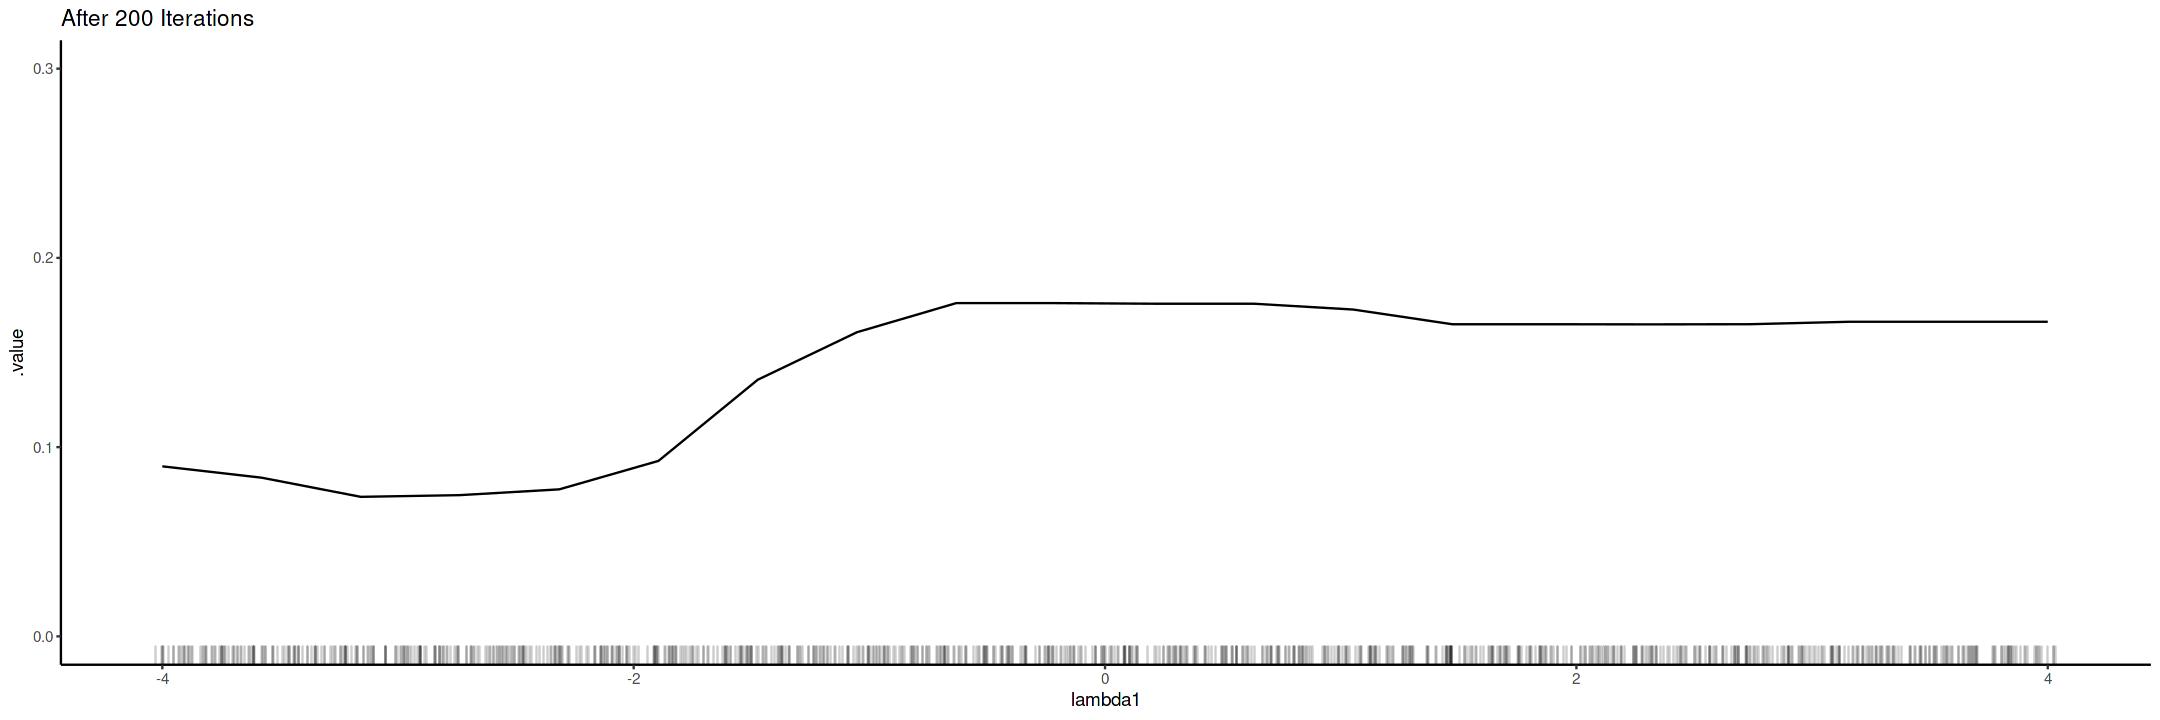

In [385]:
options(repr.plot.width=18, repr.plot.height=6)

opdf_sub = as.data.frame(grid[, c("lambda1", "lambda2")])

mymodel = makeS3Obj("mymodel", fun = function(data) return(apply(data[, c("lambda1", "lambda2")], 1, obj)))

predict.mymodel = function(object, newdata) {
    object$fun(newdata)
}

predictor = Predictor$new(model, data = opdf_sub, predict.function = predict.mymodel)
effects = FeatureEffect$new(predictor = predictor, feature = "lambda1", method = "pdp")
effects$plot() + ggtitle(paste("After", i, "Iterations")) + ylim(c(0, 0.3))

In [397]:
obj = binary_example_2
ps = getParamSet(obj)

grid = generateGridDesign(par.set = ps, resolution = 500)
grid$perf = unlist(lapply(dfRowsToList(grid, ps), obj))

grid = as.data.table(grid)

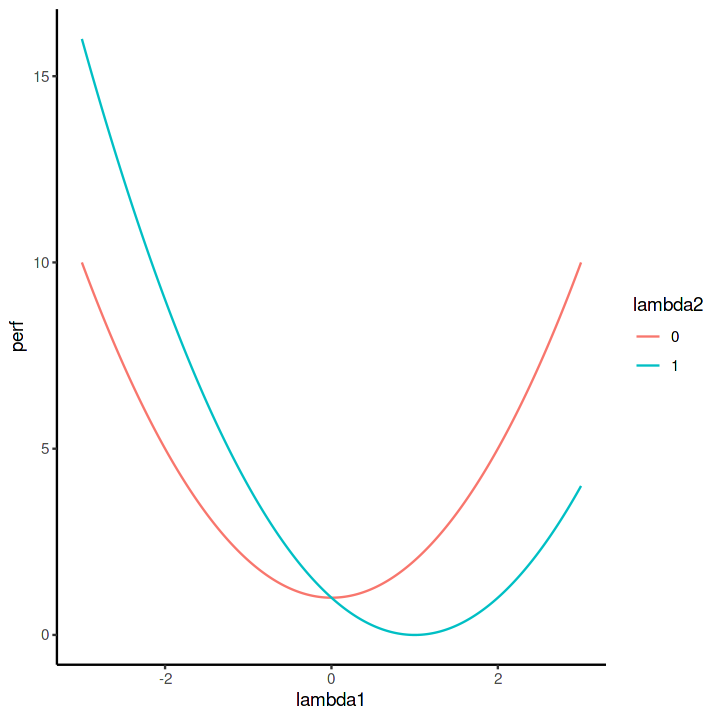

In [398]:
options(repr.plot.width=6, repr.plot.height=6)

gg = grid; gg$lambda2 = as.factor(gg$lambda2)
ggplot(data = gg, aes(x = lambda1, y = perf, colour = lambda2, group = lambda2)) + geom_line()

$gt


$gt


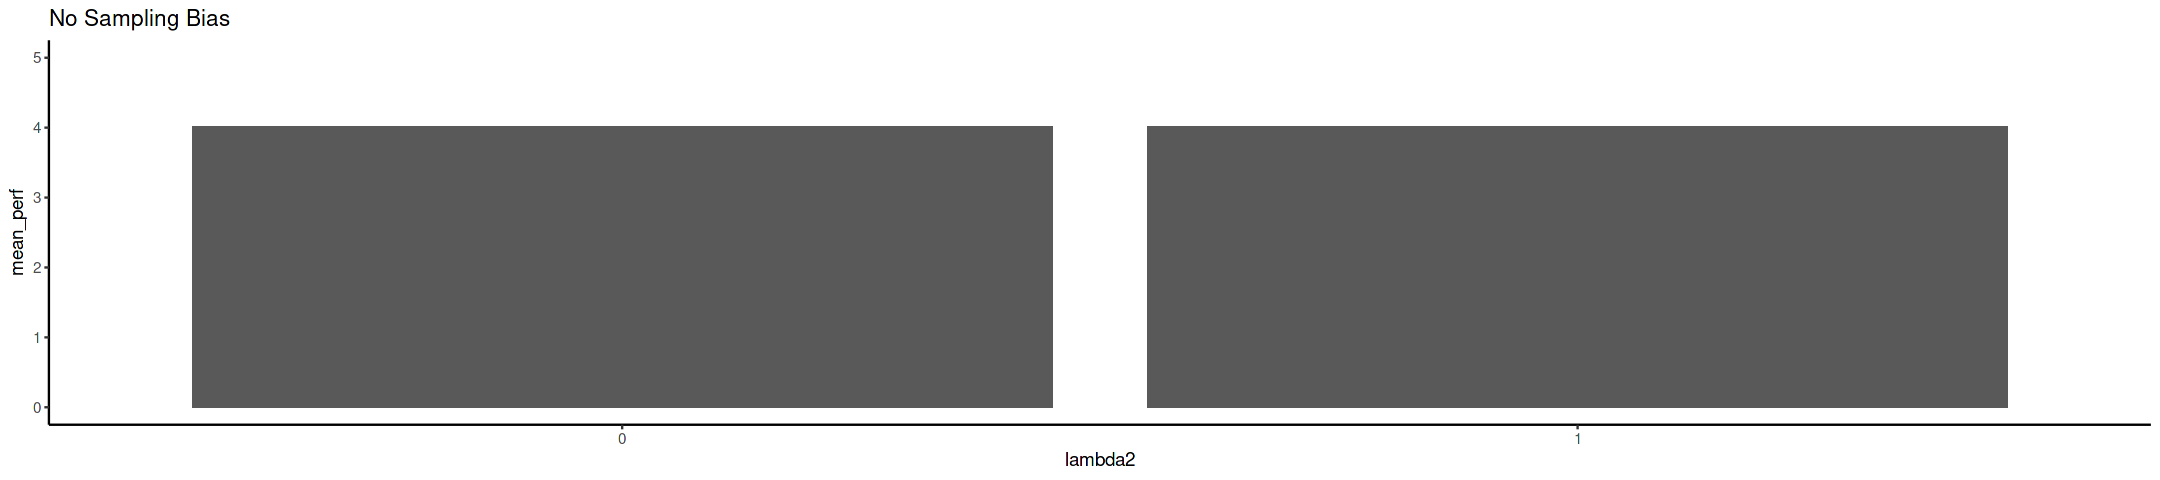

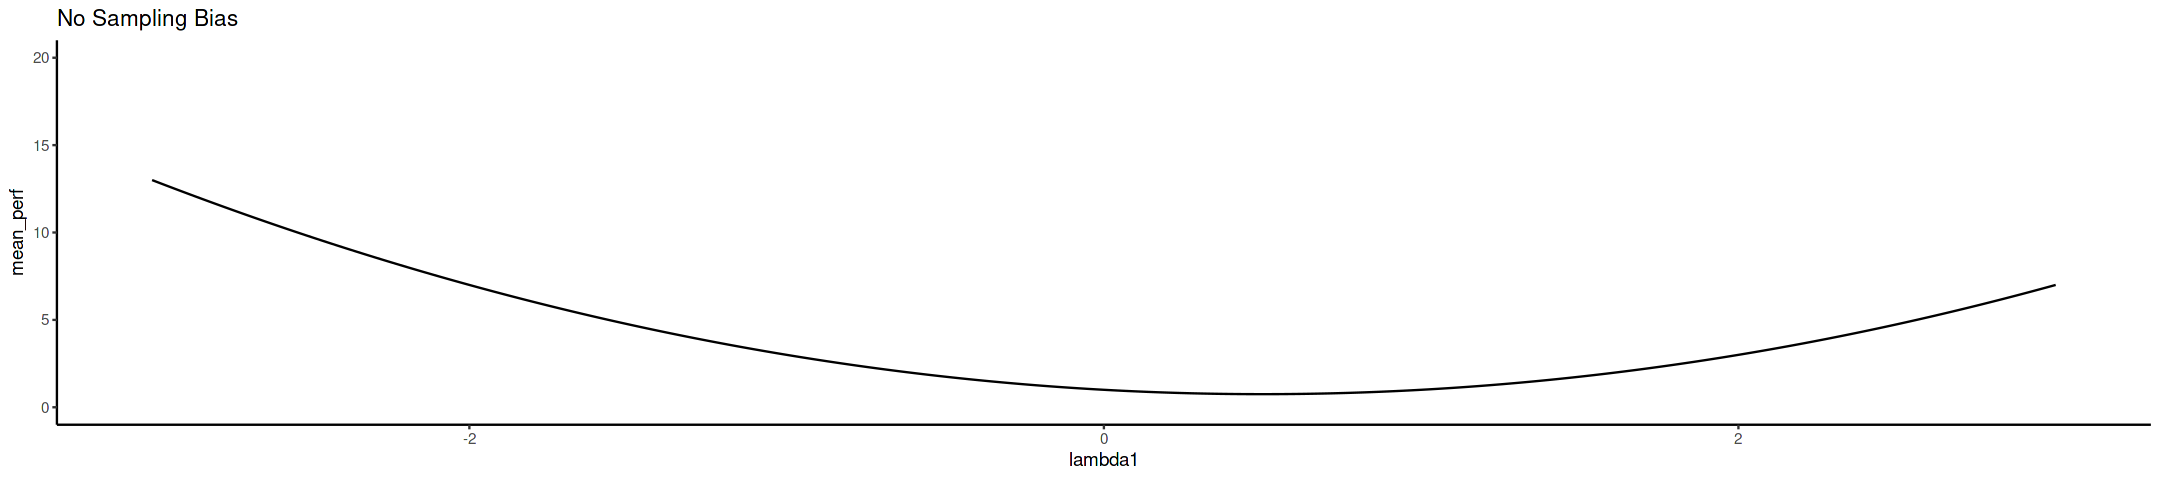

In [406]:
grid_sm = gg[, list(mean_perf = mean(perf), sd = sd(perf)), by = "lambda2"]

# p = ggplot(data = grid_sm, aes(x = lambda2, y = mean_perf, colour = lambda2)) + geom_point() # + geom_jitter(data = gg, aes(x = lambda2, y = perf), alpha = 0.2)
# p + geom_errorbar(aes(ymin = mean_perf - sd, ymax = mean_perf + sd)) + geom_hline(aes(yintercept = mean_perf, colour = lambda2))

# (p1 = ggplot(data = gg, aes(middle = mean(perf), y = perf, colour = lambda2)) + geom_boxplot())
p1 = ggplot(data = grid_sm, aes(y = mean_perf, x = lambda2)) + geom_bar(stat = "identity") + ggtitle("No Sampling Bias")
pl_lambda1 = list(gt = p1 + ylim(c(0, 5)))
pl_lambda1

grid_sm = gg[, list(mean_perf = mean(perf), sd = sd(perf)), by = "lambda1"]

p1 = ggplot(data = grid_sm, aes(x = lambda1, y = mean_perf)) + geom_line() + ggtitle("No Sampling Bias")
pl_lambda2 = list(gt = p1 + ylim(c(0, 20)))
pl_lambda2

In [401]:
# ! only run once
path = "notebook_data/binary_example_2_lambda_1.rds"
# createMBOrun(fun = obj, max.evals = 200, lambda = 1, store_path = path, init_size = 8)

In [402]:
run = readRDS(path)
model = run$models; model = model[[length(model)]]
opdf = as.data.frame(run$opt.path)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



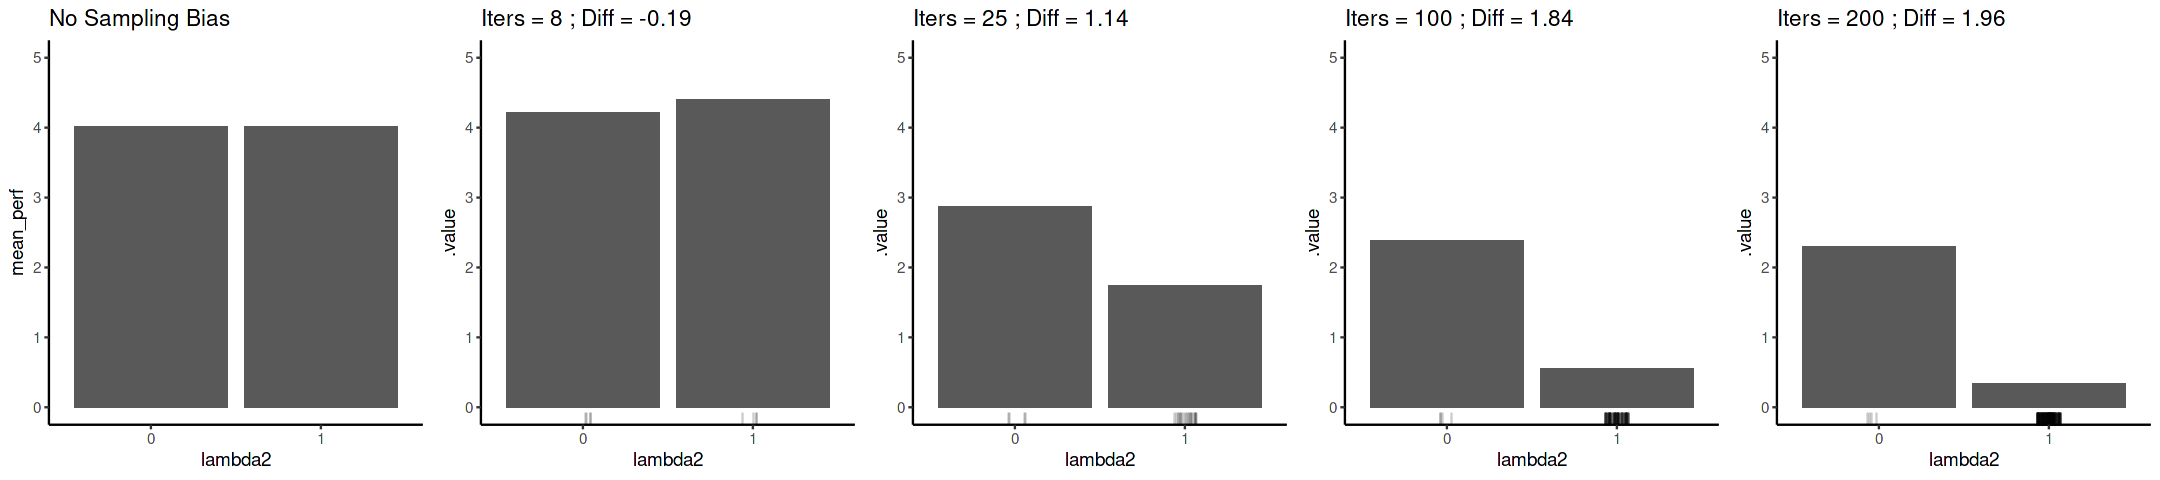

In [407]:
options(repr.plot.width=18, repr.plot.height=4)

for (i in c(8, 25, 100, 200)) {
    opdf_sub = opdf[seq_len(i), c("lambda1", "lambda2")]
    
    mymodel = makeS3Obj("mymodel", fun = function(data) return(unlist(lapply(dfRowsToList(data[, c("lambda1", "lambda2")], ps), obj))))
                        
    predict.mymodel = function(object, newdata) {
        object$fun(newdata)
    }
    
    predictor = Predictor$new(mymodel, data = opdf_sub, predict.function = predict.mymodel)
    effects = FeatureEffect$new(predictor = predictor, feature = "lambda2", method = "pdp")
    diff = effects$results$.value[2] - effects$results$.value[1]
    pl_lambda1[[paste("iter_", i, sep = "")]] = effects$plot() + ggtitle(paste("Iters =", i, "; Diff =", round(diff, 2))) + ylim(c(0, 5))
}
                        
do.call(grid.arrange, args = c(pl_lambda1, nrow = 1))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



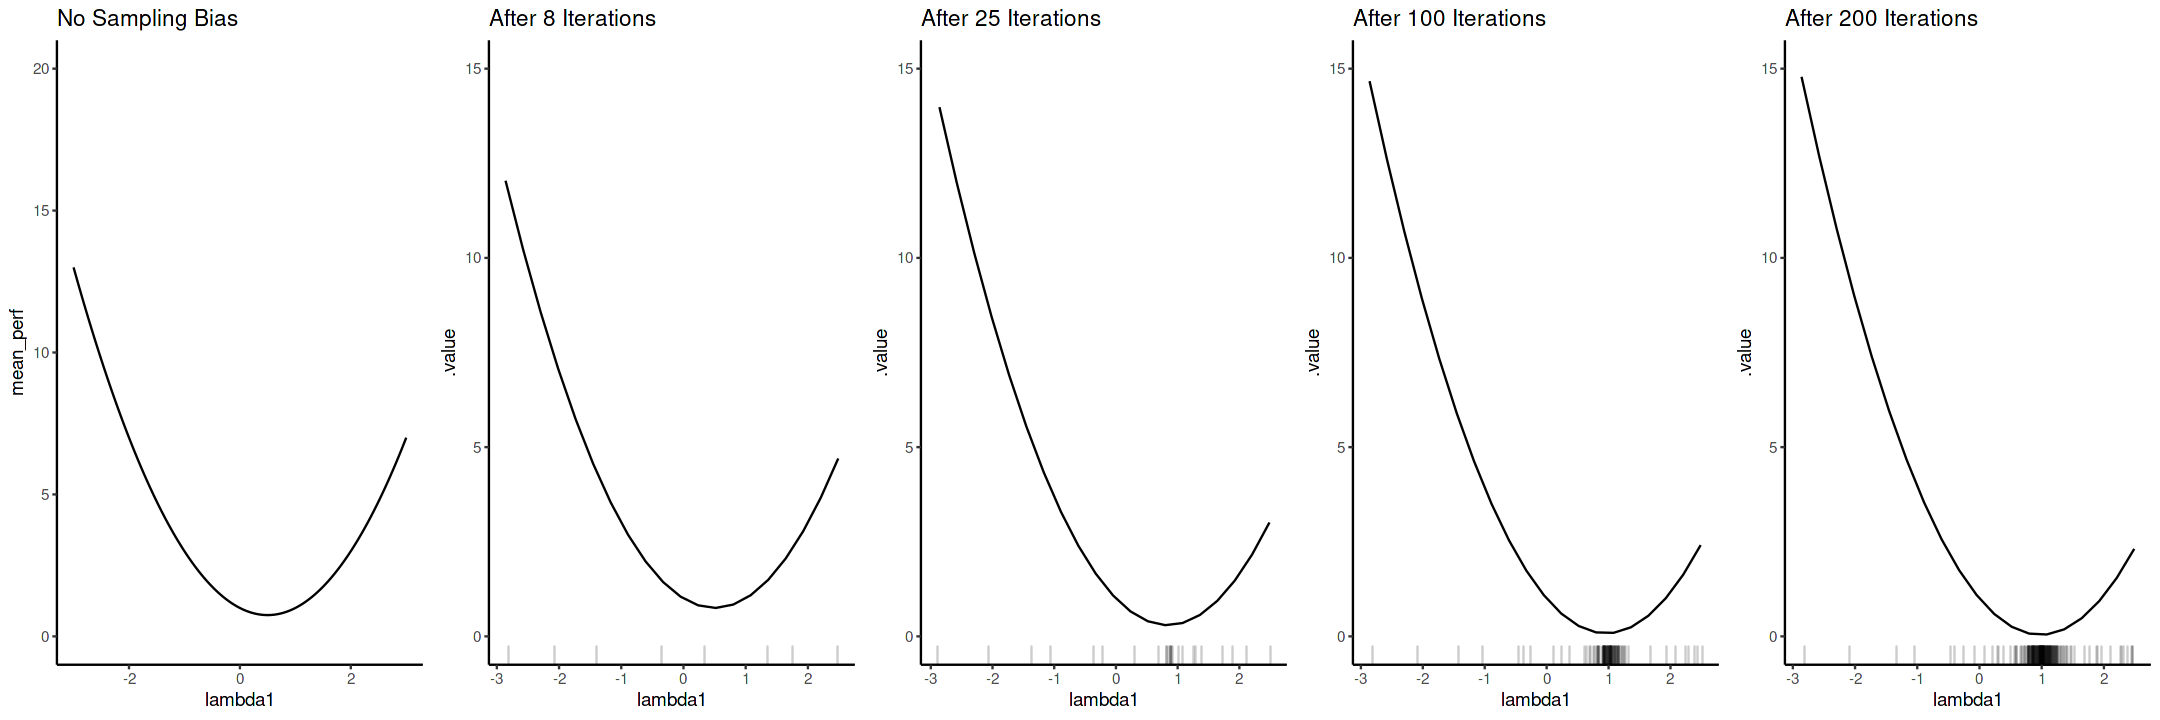

In [409]:
options(repr.plot.width=18, repr.plot.height=6)

for (i in c(8, 25, 100, 200)) {
    opdf_sub = opdf[seq_len(i), c("lambda1", "lambda2")]
    
    mymodel = makeS3Obj("mymodel", fun = function(data) return(unlist(lapply(dfRowsToList(data[, c("lambda1", "lambda2")], ps), obj))))
                        
    predict.mymodel = function(object, newdata) {
        object$fun(newdata)
    }
    
    predictor = Predictor$new(mymodel, data = opdf_sub, predict.function = predict.mymodel)
    effects = FeatureEffect$new(predictor = predictor, feature = "lambda1", method = "pdp")
    pl_lambda2[[paste("iter_", i, sep = "")]] = effects$plot() + ggtitle(paste("After", i, "Iterations")) + ylim(c(0, 15))
}
                        
do.call(grid.arrange, args = c(pl_lambda2, nrow = 1))

In [413]:
summary(opdf$lambda2)

0   1 
  4 196

### Sampling Bias

Note that applying partial dependence plots on the training data is not recommendable. 

### The Effect of Overlapping

Note that applying partial dependence plots on the training data is not recommendable. 

In [2]:


options(repr.plot.width=10, repr.plot.height=10)
theme_set(theme_bw())

Loading required package: ParamHelpers

Loading required package: checkmate


Attaching package: ‘BBmisc’


The following object is masked from ‘package:base’:

    isFALSE


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: rpart

Loading required package: tibble

Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

Loading required package: mlr

'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).



## Scenario 1 - Optimizing a Synthetic Test Function via mlrMBO

We optimize the 3D StyblinkskiTang function. 

In [3]:
obj1 = makeSingleObjectiveFunction(name = "StyblinkskiTang3D", fn = function(x) {
        1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
    }, 
    par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 2, lower = - 5, upper = 5))
)

In [4]:
data = data.frame(x1 = c(1, 2, 3), x2 = c(3, 2, 1))
data
apply(data, 1, obj1)

x1,x2
<dbl>,<dbl>
1,3
2,2
3,1


[1] -29 -38 -29

In [5]:
obj2 = makeSingleObjectiveFunction(name = "Rastrigin", fn = function(x) {
        20 + sum(x^2 - 10 * cos(2 * pi * x))
    }, 
    par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 2, lower = - 5, upper = 3))
)

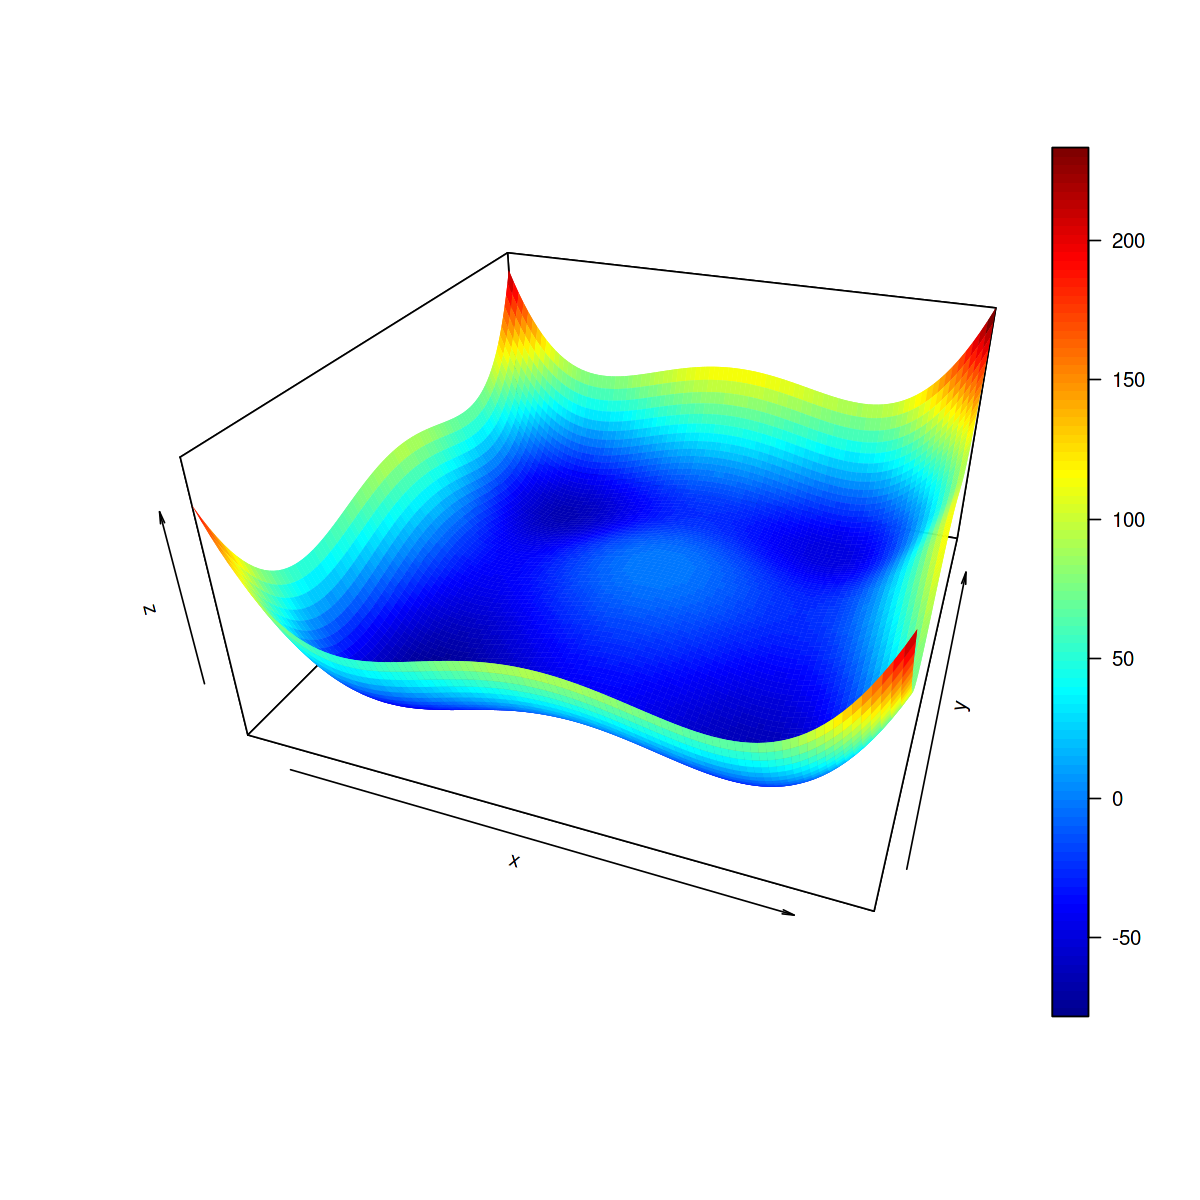

In [6]:
ps = getParamSet(obj1)

x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
x2 <- x1
y = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj1))
          
persp3D(x1, x2, y, theta = 20, phi = 30, expand = 0.5, border = NA)

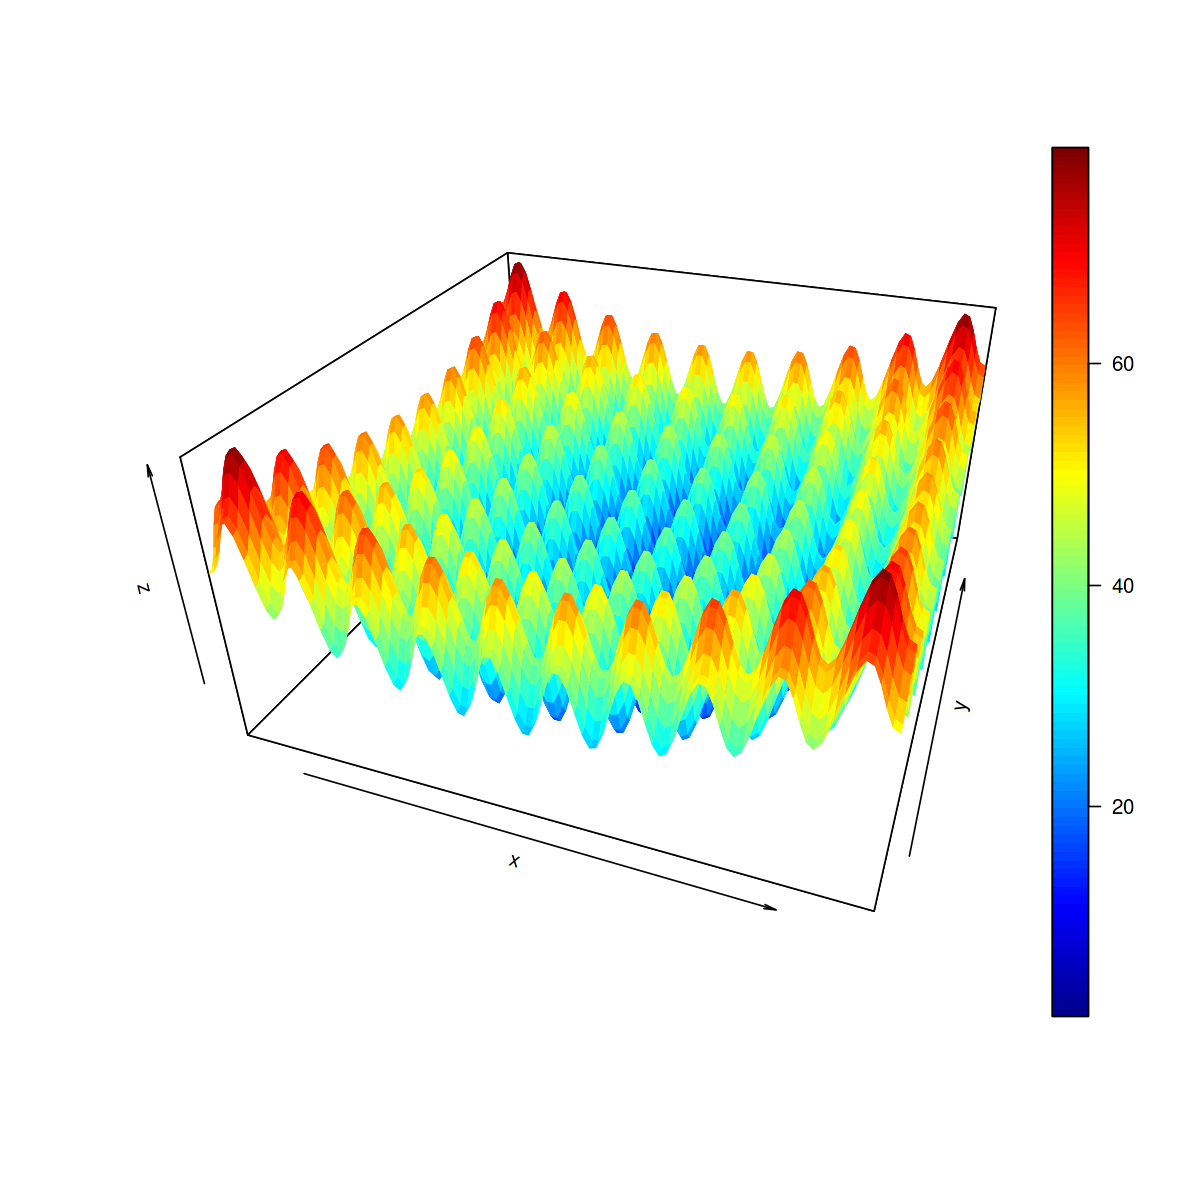

In [7]:
ps = getParamSet(obj2)

x11 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
x22 <- x11
y2 = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj2))
          
persp3D(x11, x22, y2, theta = 20, phi = 30, expand = 0.5, border = NA)

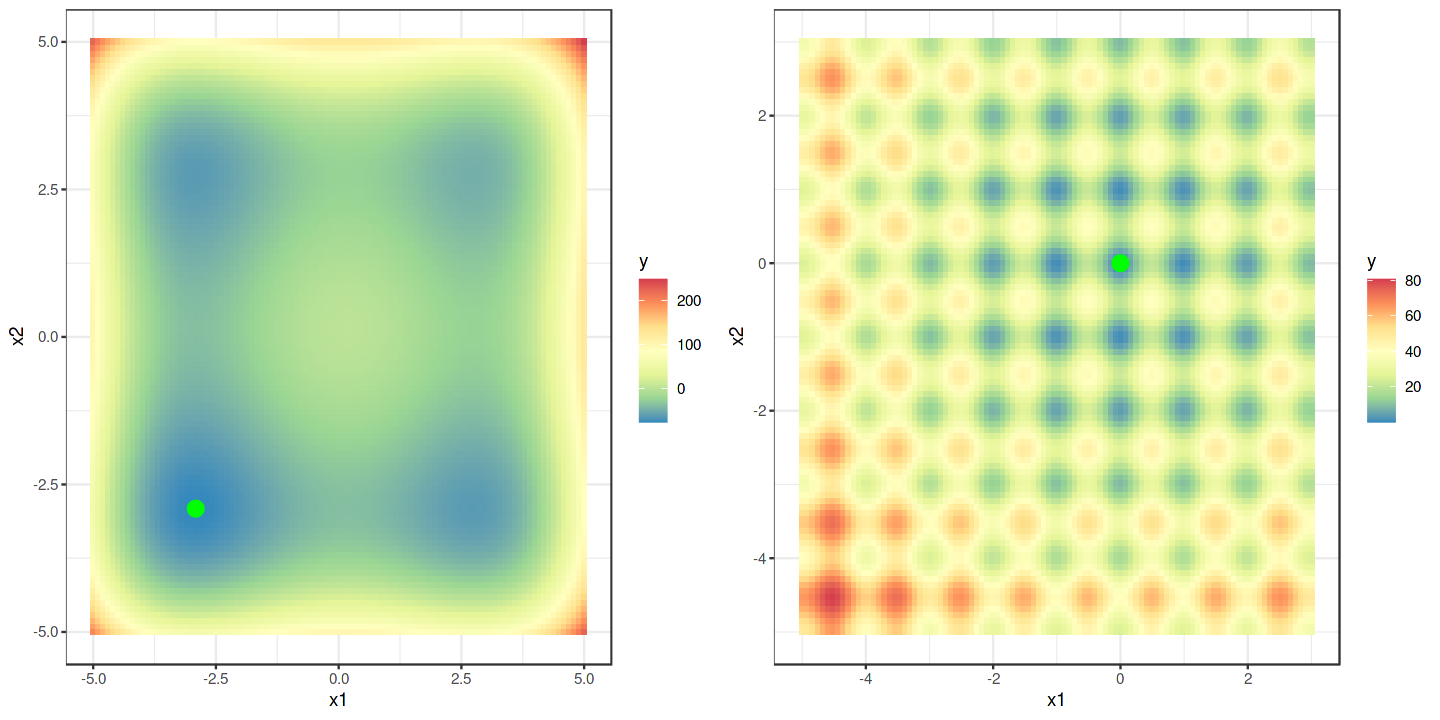

In [8]:
options(repr.plot.width=12, repr.plot.height=6)

gg <- expand.grid(x1 = x1, x2 = x2)
gg$y = apply(gg, 1, obj1)

gg2 <- expand.grid(x1 = x11, x2 = x22)
gg2$y = apply(gg2, 1, obj2)


p_obj_1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = y))
p_obj_1 = p_obj_1 + scale_fill_distiller(palette = "Spectral")
p_obj_1 = p_obj_1 + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)

p_obj_2 = ggplot() + geom_tile(data = gg2, aes(x = x1, y = x2, fill = y))
p_obj_2 = p_obj_2 + scale_fill_distiller(palette = "Spectral")
p_obj_2 = p_obj_2 + geom_point(data = data.frame(x = 0, y = 0), aes(x = x, y = y), colour = "green", size = 4)

grid.arrange(p_obj_1, p_obj_2, ncol = 2)

### Computing the PDP on Training or Test Data? 

A partial dependence plot tries to approximate the following: 

\begin{align*}
\hat f(x_S) & = \mathbb{E}_{x_C}[\hat f(x_S, x_C)] = \int \hat f(x_S, x_C) d\mathbb{P}(x_C)
\end{align*}

The mathematical correct variants of the ground-truth for $\hat f = f$ look like this: 

* Data situation 1: Ground-truth objective and $\mathbb{P}$ is the uniform distribution (ideal world)

\begin{align*}
\hat f_1(x_1) & = (-25 + 15 x_1 - 48 x_1^2 + 3 x_1^4) / 6 \\
\hat f_2(x_1) & = 8 x_1^2 - 80 cos(2 \pi x_1) + 632/3
\end{align*}

* Data situation 2: Ground-truth objective and $\mathbb{P}$ is the distribution from a perfect optimizer which immediately detects the optimum at $x^* = (-2.903.., - 2.903)$.

\begin{align*}
\hat f(x_1) & = 0.5 (x_1^4 - 16 x_1^2 + 5 x_1 - 78.3323) \\
\hat f_2(x_1) &= 20 + x_1^2 - 10 \cos(2 \pi x_1) - 10
\end{align*}

If we fit a PDP on the MBO data we usually approximate something in between. 

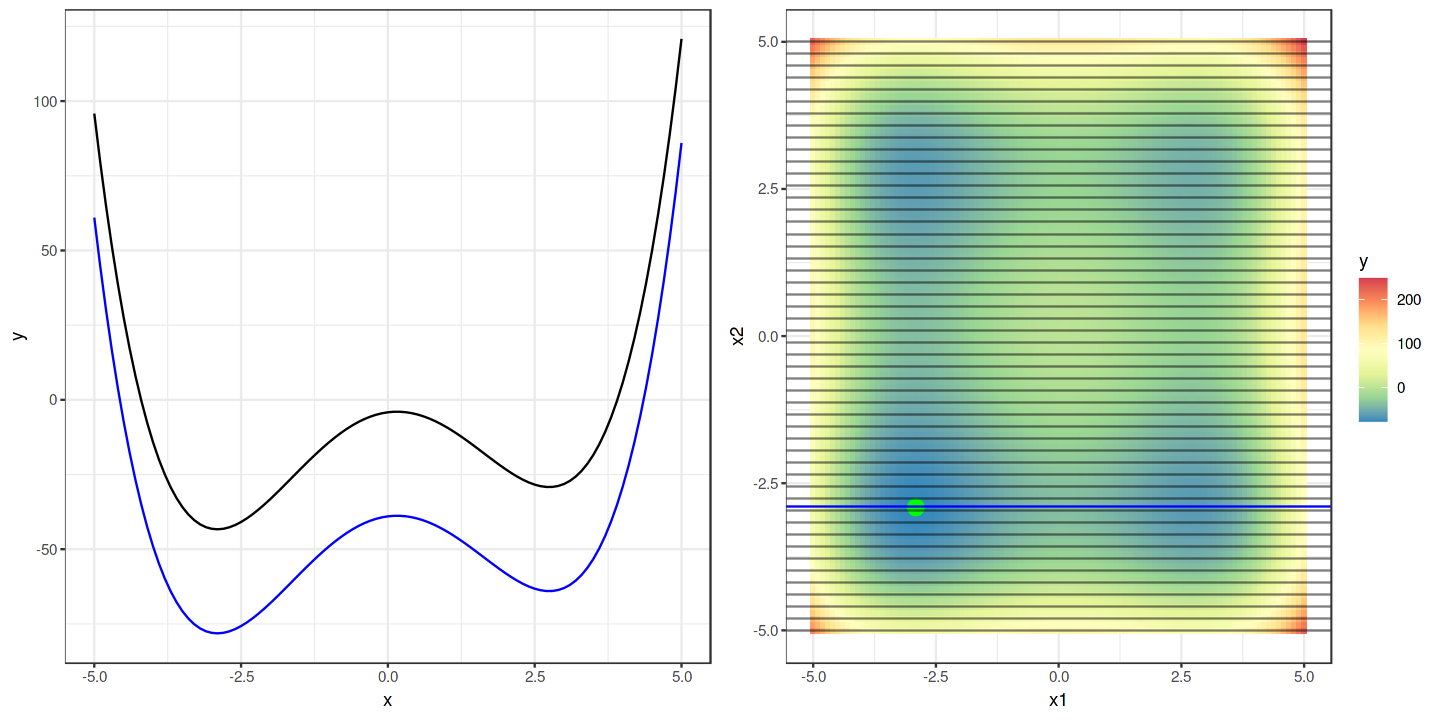

In [8]:
p1 = ggplot() + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 6 * (3 * x^4 - 48 * x^2 + 15 * x - 25))
lines = seq(-5, 5, length.out = 50)
p1 = p1 + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 2 * (x^4 - 16 * x^2 + 5 * x - 78), colour = "blue")
p2 = p_obj_1 + geom_hline(data = data.frame(yintercept = lines), aes(yintercept = yintercept), alpha = 0.5)
p2 = p2 + geom_hline(aes(yintercept = -2.903), colour = "blue")

options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(p1, p2, ncol = 2)

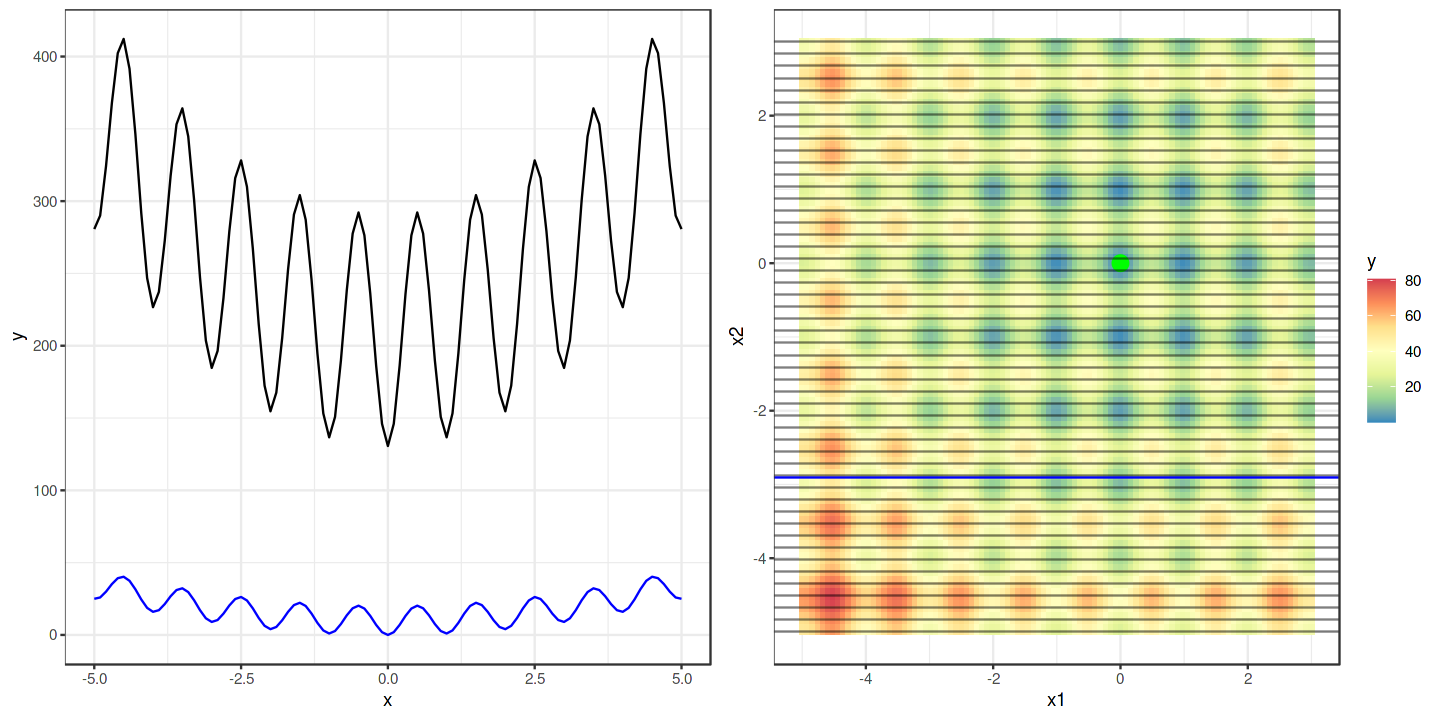

In [9]:
p1 = ggplot() + stat_function(data = data.frame(x = c(-5, 3)), aes(x = x), fun = function(x) 6 * x^2 - 80 * cos(2 * pi * x) + 632 / 3)
lines = seq(-5, 3, length.out = 50)
p1 = p1 + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 20 + x^2 - 10 * cos(2 * pi * x) - 10, colour = "blue")
p2 = p_obj_2 + geom_hline(data = data.frame(yintercept = lines), aes(yintercept = yintercept), alpha = 0.5)
p2 = p2 + geom_hline(aes(yintercept = -2.903), colour = "blue")

options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(p1, p2, ncol = 2)

In case 1 we are interested in the average feature effect of $x_1$ on $y$.

In case 2 we are interested in the feature effect of $x_1$ on $y$ given $x_2 = x_2^*$.

Usually, what we approximate is something in between but we converge to scenario 2. 

### Considering MBO Runs

Next, we create `mlrMBO` runs as well as a model fitted on the randomLHS data. 

In [10]:
createMBOrun = function(fun, max.evals, lambda, store_path, init_size = NULL) {
    
    ps = getParamSet(fun)

    ctrl = makeMBOControl(store.model.at = seq_len(max.evals))
    ctrl = setMBOControlTermination(ctrl, max.evals = max.evals)
    ctrl = setMBOControlInfill(ctrl, makeMBOInfillCritCB(cb.lambda = lambda))

    if (is.null(init_size))
        init_size = 4 * getParamLengths(ps)
        
    des = generateDesign(n = init_size, par.set = ps, fun = lhs::randomLHS)
    
    res = mbo(obj, design = des, control = ctrl, show.info = TRUE)
    
    saveRDS(res, store_path)
}

In [733]:
createMBOrun(fun = obj, max.evals = 50, lambda = 0.1, store_path = "synthetic/mlrmbo_run_StyblinkskiTang3D_01.rds")

Computing y column(s) for design. Not provided.

[mbo] 0: x=4.11,4.35 : y = 56.1 : 0.0 secs : initdesign

[mbo] 0: x=-1.58,-3.48 : y = -53 : 0.0 secs : initdesign

[mbo] 0: x=-4.92,-0.27 : y = 86 : 0.0 secs : initdesign

[mbo] 0: x=2.57,2.94 : y = -49 : 0.0 secs : initdesign

[mbo] 0: x=1.98,-1.9 : y = -45.8 : 0.0 secs : initdesign

[mbo] 0: x=-0.719,-5 : y = 93.8 : 0.0 secs : initdesign

[mbo] 0: x=-2.62,2.46 : y = -61.9 : 0.0 secs : initdesign

[mbo] 0: x=0.839,0.667 : y = -5.07 : 0.0 secs : initdesign

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 1: x=-1.04,2.57 : y = -35.3 : 0.0 secs : infill_cb

[mbo] 2: x=-4.02,2.39 : y = -31.9 : 0.0 secs : infill_cb

[mbo] 3: x=-2.43,2.46 : y = -59.8 : 0.0 secs : infill_cb

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 4: 

In [734]:
createMBOrun(fun = obj, max.evals = 50, lambda = 1, store_path = "synthetic/mlrmbo_run_StyblinkskiTang3D_1.rds")

Computing y column(s) for design. Not provided.

[mbo] 0: x=-0.996,4.38 : y = 31.8 : 0.0 secs : initdesign

[mbo] 0: x=-1.86,0.22 : y = -26.1 : 0.0 secs : initdesign

[mbo] 0: x=2.19,-1.57 : y = -41.9 : 0.0 secs : initdesign

[mbo] 0: x=2.55,-4.43 : y = 0.191 : 0.0 secs : initdesign

[mbo] 0: x=-3.97,-3.57 : y = -41.8 : 0.0 secs : initdesign

[mbo] 0: x=4.29,1.36 : y = 22.7 : 0.0 secs : initdesign

[mbo] 0: x=0.996,-0.983 : y = -14.7 : 0.0 secs : initdesign

[mbo] 0: x=-3.1,3.67 : y = -46.3 : 0.0 secs : initdesign

[mbo] 1: x=4.34,-1.89 : y = 10.4 : 0.0 secs : infill_cb

[mbo] 2: x=-3.19,1.94 : y = -55.8 : 0.0 secs : infill_cb

[mbo] 3: x=-3.38,-0.0856 : y = -34.9 : 0.0 secs : infill_cb

[mbo] 4: x=-3.18,-4.68 : y = 15.6 : 0.0 secs : infill_cb

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 5: x=-1.28,1.99 : y = -33.9 : 0.0 secs : infill_cb

[mbo] 6: x=-4.36,1.9 : y = -0.0174

In [735]:
createMBOrun(fun = obj, max.evals = 50, lambda = 10, store_path = "synthetic/mlrmbo_run_StyblinkskiTang3D_10.rds")

Computing y column(s) for design. Not provided.

[mbo] 0: x=1.1,-4.6 : y = 37.4 : 0.0 secs : initdesign

[mbo] 0: x=2.6,5 : y = 100 : 0.0 secs : initdesign

[mbo] 0: x=4.52,1.33 : y = 47.2 : 0.0 secs : initdesign

[mbo] 0: x=1.47,-2.47 : y = -47.6 : 0.0 secs : initdesign

[mbo] 0: x=-3.6,-3.75 : y = -51.8 : 0.0 secs : initdesign

[mbo] 0: x=-0.596,2.64 : y = -29.1 : 0.0 secs : initdesign

[mbo] 0: x=-4.05,0.484 : y = -7.58 : 0.0 secs : initdesign

[mbo] 0: x=-1.94,-0.295 : y = -29.3 : 0.0 secs : initdesign

[mbo] 1: x=2.1,-4.21 : y = -15.6 : 0.0 secs : infill_cb

[mbo] 2: x=-3.4,-1.35 : y = -50.4 : 0.0 secs : infill_cb

[mbo] 3: x=-3,5 : y = 86 : 0.0 secs : infill_cb

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 4: x=5,-1.15 : y = 112 : 0.0 secs : infill_cb

[mbo] 5: x=-1.54,-5 : y = 80 : 0.0 secs : infill_cb

[mbo] 6: x=0.993,0.935 : y = -9.19 : 0.0 secs : infill_cb

[mbo]

In [803]:
createMBOrun(fun = obj, max.evals = 51, lambda = 11, store_path = "synthetic/mlrmbo_run_StyblinkskiTang3D_lhs.rds", init_size = 50)

Computing y column(s) for design. Not provided.

[mbo] 0: x=3.9,-2.88 : y = -35.3 : 0.0 secs : initdesign

[mbo] 0: x=-2.41,-4.82 : y = 36 : 0.0 secs : initdesign

[mbo] 0: x=-0.813,-3.53 : y = -37.9 : 0.0 secs : initdesign

[mbo] 0: x=0.81,-0.411 : y = -5.38 : 0.0 secs : initdesign

[mbo] 0: x=1.31,-1.97 : y = -37.5 : 0.0 secs : initdesign

[mbo] 0: x=2.86,-1.13 : y = -37 : 0.0 secs : initdesign

[mbo] 0: x=-3.76,4.19 : y = 1.3 : 0.0 secs : initdesign

[mbo] 0: x=-3.11,1.61 : y = -51.8 : 0.0 secs : initdesign

[mbo] 0: x=-4.49,0.229 : y = 31.2 : 0.0 secs : initdesign

[mbo] 0: x=0.72,1.53 : y = -14.3 : 0.0 secs : initdesign

[mbo] 0: x=3.09,-4.79 : y = 44.6 : 0.0 secs : initdesign

[mbo] 0: x=-3.85,0.695 : y = -20.3 : 0.0 secs : initdesign

[mbo] 0: x=-3.55,4.67 : y = 45.2 : 0.0 secs : initdesign

[mbo] 0: x=4.53,-1.28 : y = 43.1 : 0.0 secs : initdesign

[mbo] 0: x=-1.16,-0.136 : y = -13.2 : 0.0 secs : initdesign

[mbo] 0: x=4.23,1.26 : y = 19.2 : 0.0 secs : initdesign

[mbo] 0: x=-2.

In [10]:
runs = list(# lambda01 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang3D_01.rds"), 
            lambda1 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang3D_1.rds"),
            # lambda10 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang3D_10.rds"), 
            lhs = readRDS("synthetic//mlrmbo_run_StyblinkskiTang3D_lhs.rds"))

In [11]:
# concatenate the opt.paths
opdf = lapply(runs, function(x) {
    df = as.data.table(as.data.frame(x$opt.path))
    names(df)[ncol(df)] = "cb.lambda"
    df$cb.lambda.t = paste("lambda", df$cb.lambda[!is.na(df$cb.lambda)][1], sep = "")
    if (11 %in% df$cb.lambda)
        df$cb.lambda.t = "LHS"
    return(df)
    }
)

opdf = do.call(rbind, opdf)
opdf$cb.lambda.t = as.factor(opdf$cb.lambda.t)

models = lapply(seq_along(runs), function(i) {
    df = as.data.table(as.data.frame(runs[[i]]$opt.path))
    names(df)[ncol(df)] = "cb.lambda"
    models = runs[[i]]$models
    model = models[[length(models)]]
    if (11 %in% df$cb.lambda)
        model = models[[1]]
    return(model)
    })
names(models) = unique(opdf$cb.lambda.t)

In [12]:
summary(opdf)

       x1                x2                y                dob       
 Min.   :-4.8635   Min.   :-4.8176   Min.   :-78.332   Min.   : 0.00  
 1st Qu.:-2.9388   1st Qu.:-2.9059   1st Qu.:-77.862   1st Qu.: 0.00  
 Median :-2.7450   Median :-1.6480   Median :-37.946   Median : 0.00  
 Mean   :-1.1147   Mean   :-0.6549   Mean   :-28.538   Mean   : 8.95  
 3rd Qu.: 0.9958   3rd Qu.: 1.9391   3rd Qu.: -6.677   3rd Qu.:17.00  
 Max.   : 4.9992   Max.   : 4.9999   Max.   :249.854   Max.   :42.00  
                                                                      
      eol      error.message        exec.time               cb         
 Min.   : NA   Length:101         Min.   :0.000e+00   Min.   :-313.31  
 1st Qu.: NA   Class :character   1st Qu.:0.000e+00   1st Qu.: -78.39  
 Median : NA   Mode  :character   Median :0.000e+00   Median : -78.34  
 Mean   :NaN                      Mean   :4.951e-05   Mean   : -79.45  
 3rd Qu.: NA                      3rd Qu.:0.000e+00   3rd Qu.: -69.06  


In [13]:
head(models)

$lambda1
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 50; features = 2
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

$LHS
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 50; features = 2
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08


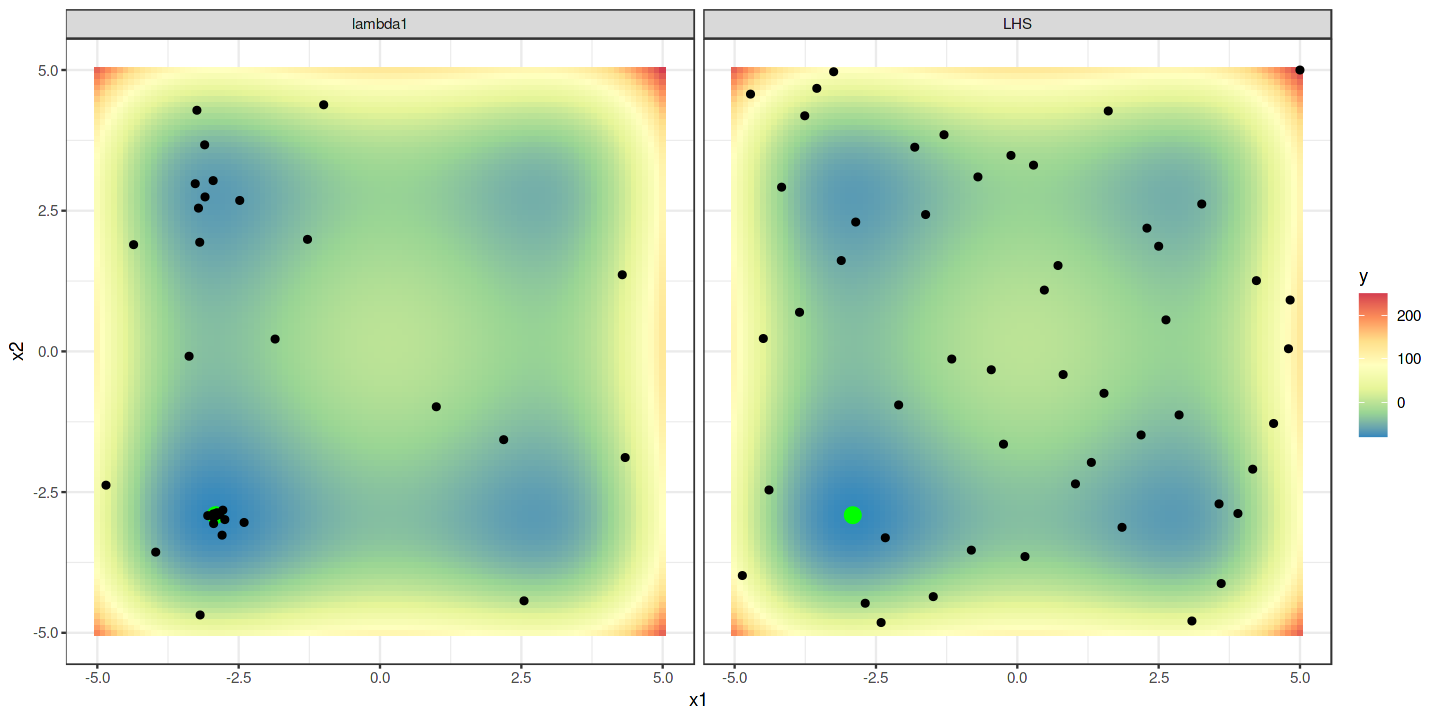

In [14]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = p_obj_1 + geom_point(data = opdf[cb.lambda.t %in% c("lambda1", "LHS"),], aes(x = x1, y = x2)) 
p1 = p1 + facet_grid(. ~ cb.lambda.t) 
p1

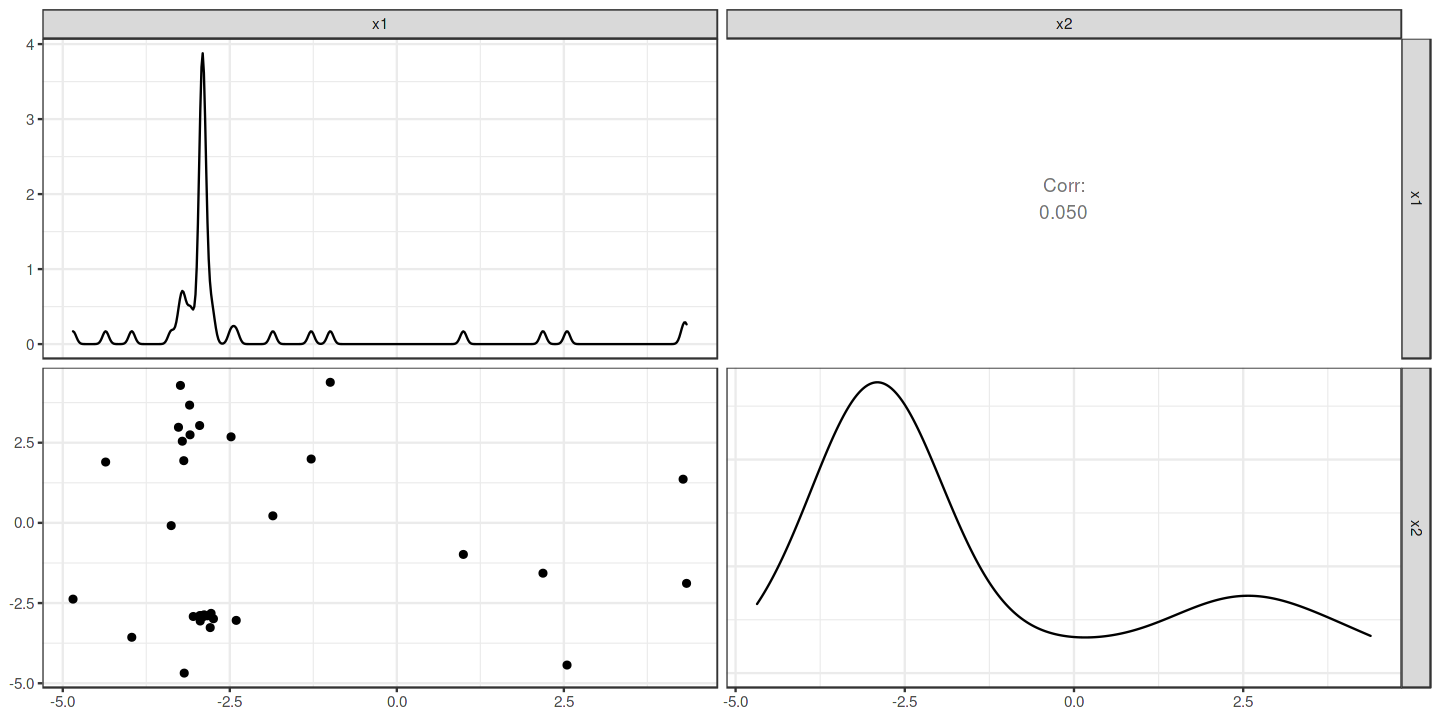

In [15]:
ggpairs(opdf[cb.lambda.t == "lambda1", c("x1", "x2")])

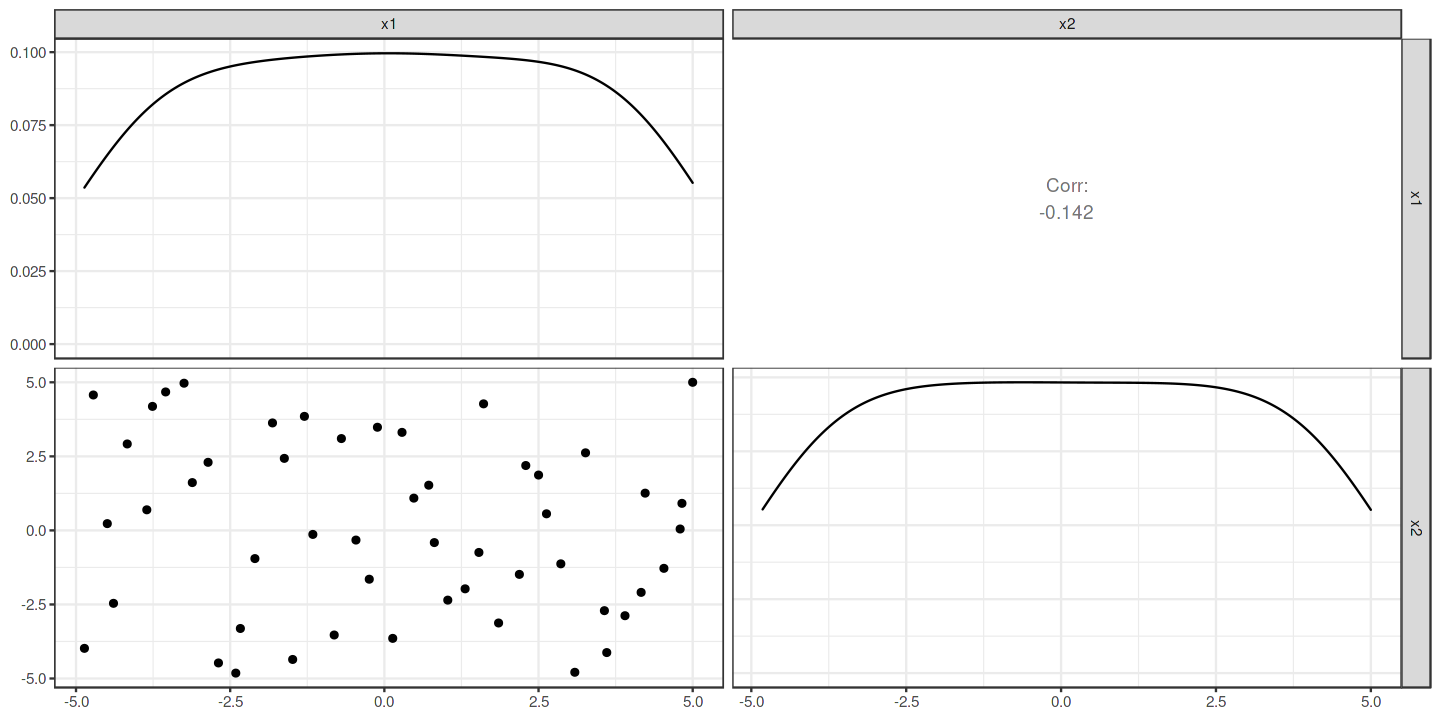

In [16]:
ggpairs(opdf[cb.lambda.t == "LHS", c("x1", "x2")])

Now, we investigate the fit. 

In [17]:
# We create a huge design 
x1 = seq(-5, 5, length.out = 50)

gg <- expand.grid(x1 = x1, x2 = x1)
gg$y = apply(gg, 1, obj1)

In [18]:
# mods = c("lambda0.1", "lambda1", "lambda10", "LHS")
mods = c("lambda1", "LHS")

preds = lapply(seq_along(models), function(i) {
    pred = predict(models[[i]], newdata = gg)$data
    pred$residual = pred$response - gg$y
    pred$abs_error = abs(pred$response - gg$y)
    pred$cb.lambda.t = mods[i]
    cbind(gg, pred)
    }
)

In [19]:
preds = do.call(rbind, preds)

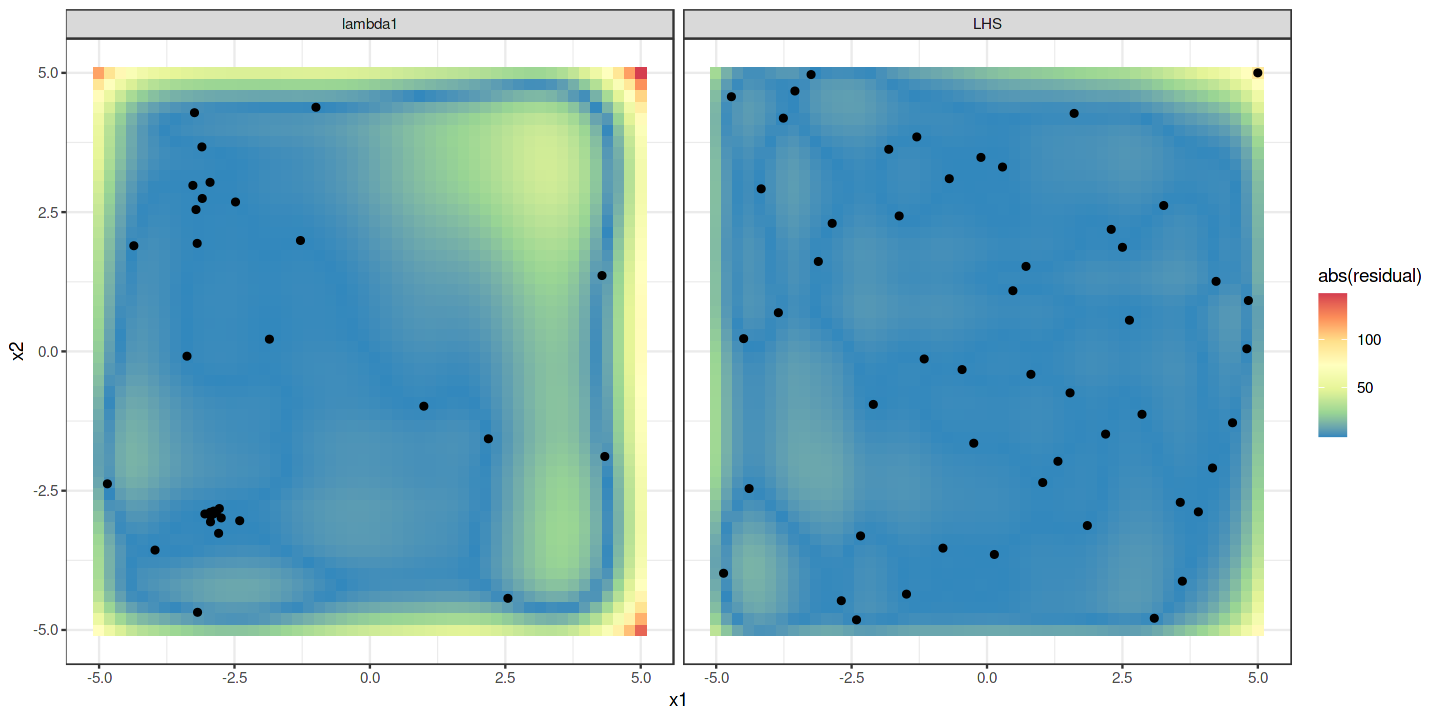

In [20]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = abs(residual)))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ cb.lambda.t)

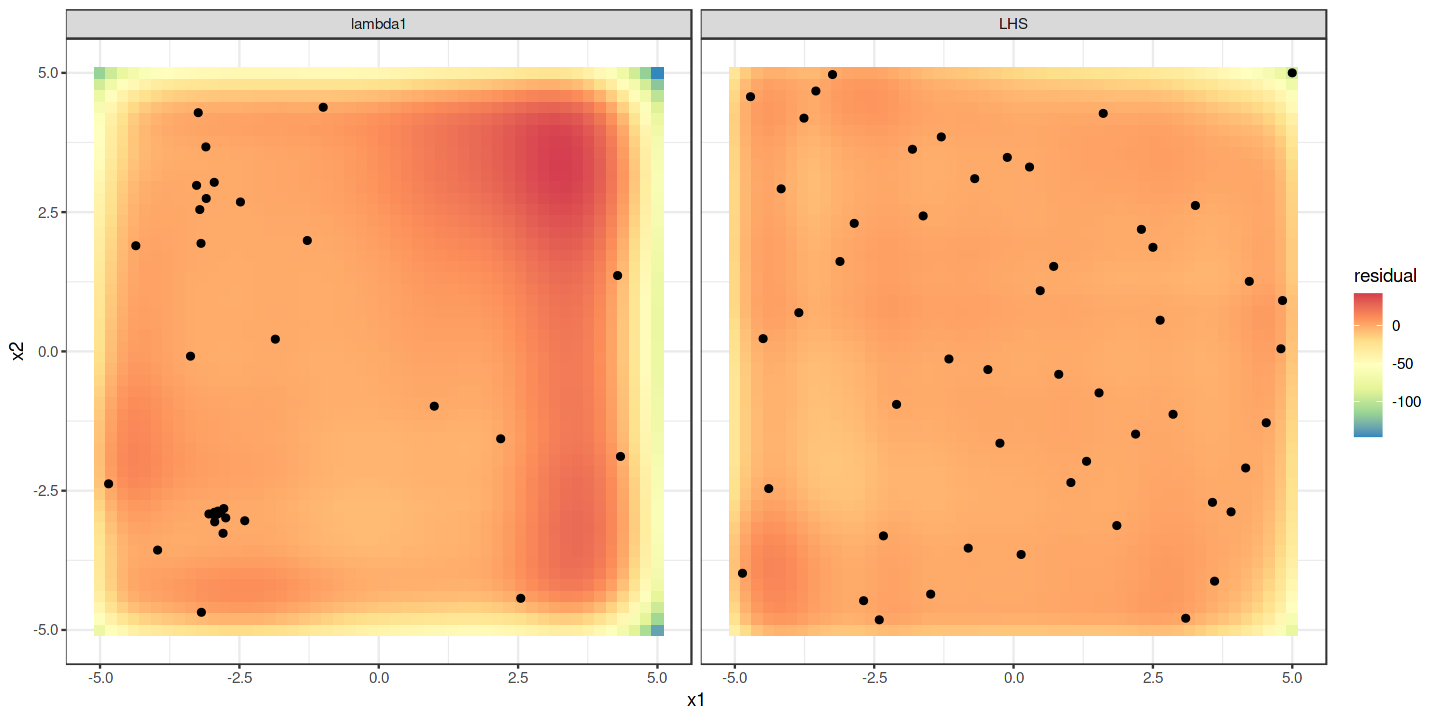

In [21]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = residual))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ cb.lambda.t)

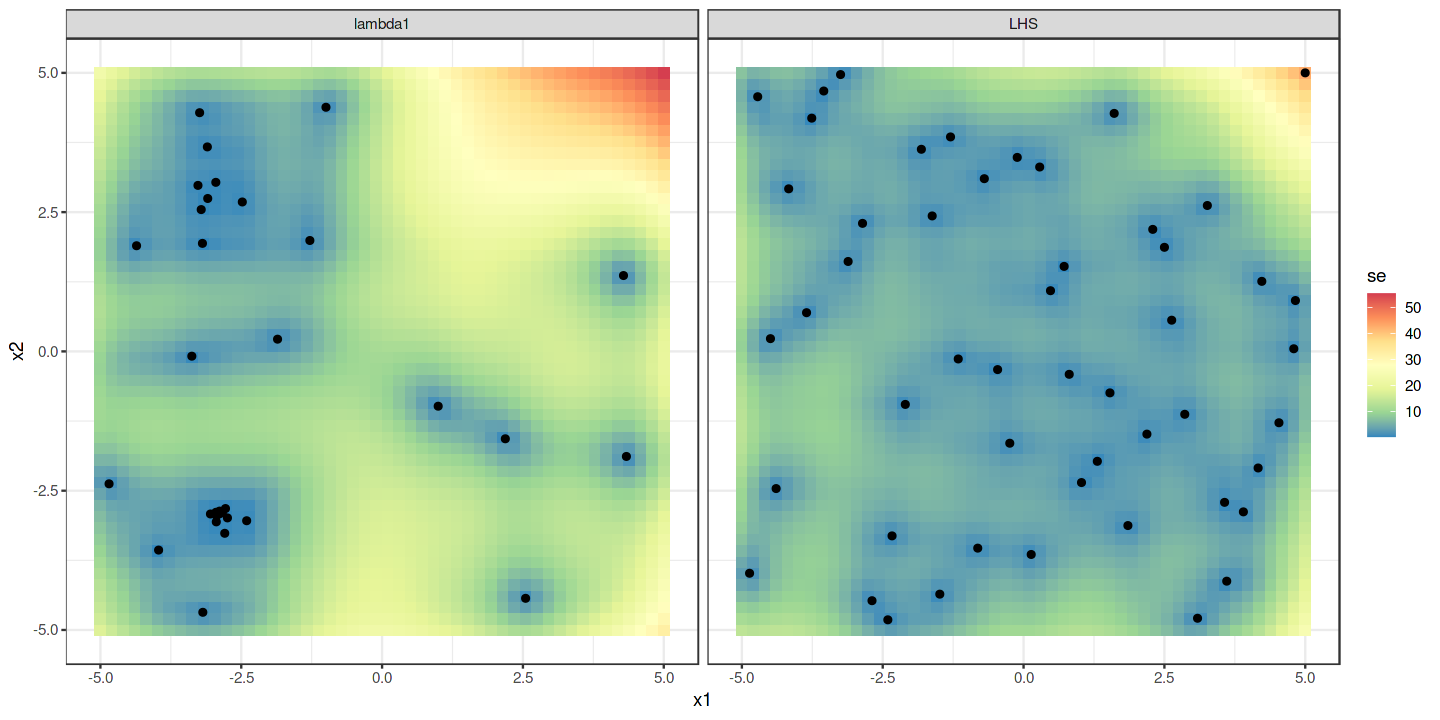

In [22]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ cb.lambda.t)

# High error means over-estimation 

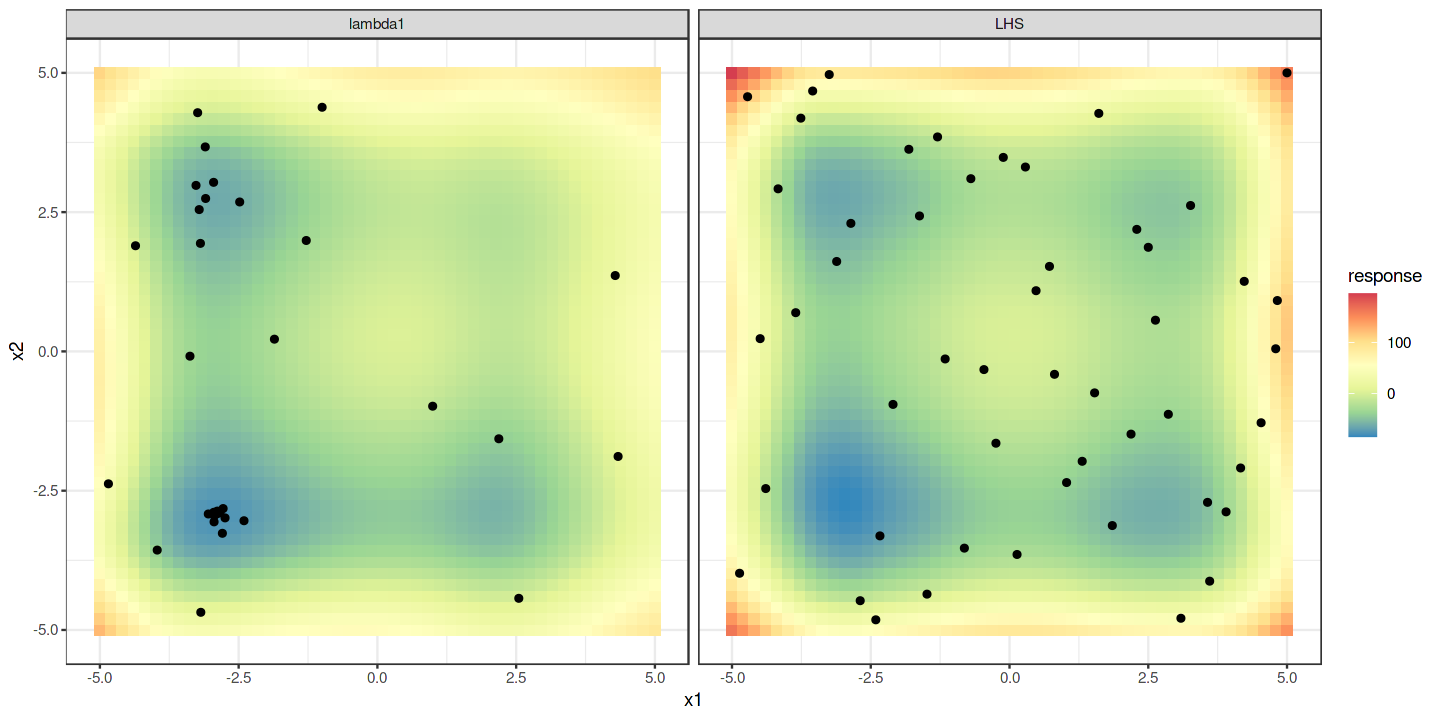

In [23]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = response))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ cb.lambda.t)

# High error means over-estimation 

Now, we investigate the PDPs (as a first start). 

In [39]:
gtPDP = function(obj, feature, opdf_sub) {
        
    mymodel = makeS3Obj("mymodel", fun = function(data) return(apply(data[, c("x1", "x2")], 1, obj)))
                        
    predict.mymodel = function(object, newdata) {
        object$fun(newdata)
    }
                        
    predictor = Predictor$new(model = mymodel, data = opdf_sub[c("x1", "x2")], predict.function = predict.mymodel)
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp")
                    
    return(effects)
}

In [40]:
getPDPSE = function(model, feature, opdf_sub, method = "pdp") {

    mod = model
    mymodel = makeS3Obj("mymodel", fun = function() return(mod))
    
    predict.mymodel = function(object, newdata) {
      pred = predict(object$fun(), newdata = newdata)
      getPredictionSE(pred)
    }

    predictor = Predictor$new(mymodel, data = opdf_sub[c("x1", "x2")], predict.function = predict.mymodel)
    
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = method)
    return(effects)
}

In [41]:
plotPDP = function(obj, model, runtype, feature, gt = FALSE, se = FALSE) {
    
    opdf_sub = generateRandomDesign(500, getParamSet(obj))

    predictor = Predictor$new(model, data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp")
    res = effects$results
    p = effects$plot() + ggtitle(runtype)
    if (gt) {
        df = gtPDP(obj, feature, opdf_sub)$results
        p = p + geom_line(data = df, aes_string(x = feature, y = ".value"), colour = "blue", lty = 2)
    }    
    if (se) {
        df = getPDPSE(model, feature, opdf_sub)$results
        res$se = df$.value
        res$upper = res$.value + 2 * res$se
        res$lower = res$.value - 2 * res$se
        p = p + geom_ribbon(data = res, aes_string(x = feature, ymin = "lower", ymax = "upper"), fill = "grey", alpha = 0.5)        
    }
    return(p)
}

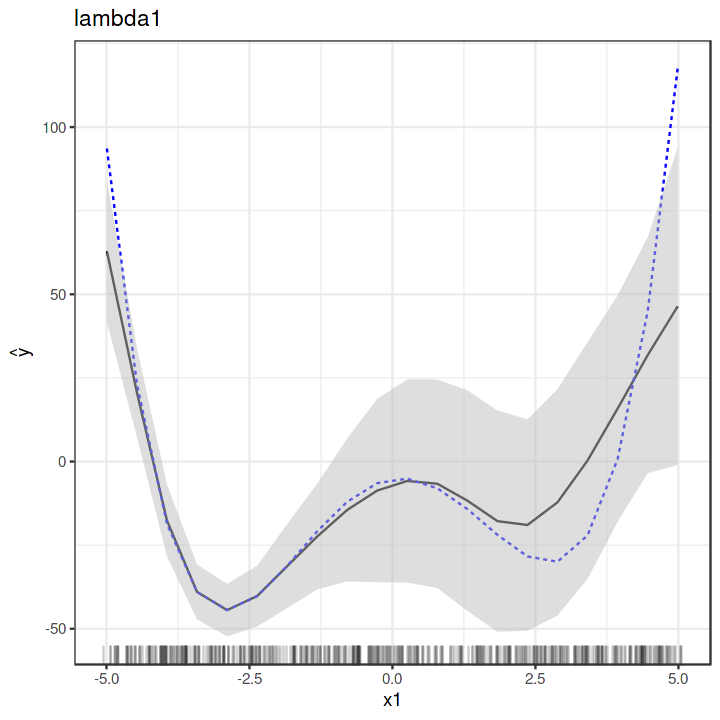

In [44]:
options(repr.plot.width = 6, repr.plot.height = 6)

plotPDP(obj1, models[["lambda1"]], "lambda1", "x1", gt = TRUE, se = TRUE)

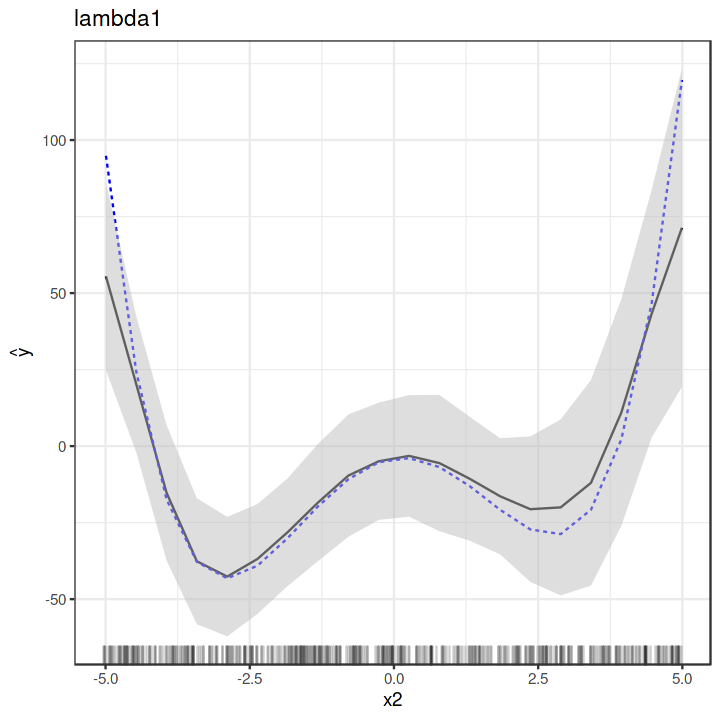

In [45]:
options(repr.plot.width = 6, repr.plot.height = 6)

plotPDP(obj1, models[["lambda1"]], "lambda1", "x2", gt = TRUE, se = TRUE)

In [34]:
testdata_runtype = "LHS"
runtype = "lambda1"
feature = "x1"
opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])

predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "ice")
eff = effects$results
names(eff)[1:2] = c("x", "y")

ice_data = getPDPSE("lambda1", "x1", "LHS", "ice")$results
names(ice_data)[1:2] = c("x", "se")

df = merge(eff, ice_data, by = c("x", ".type", ".id"))

In [35]:
se_max = max(df$se)
df$weight = (se_max - df$se) / se_max

In [36]:
df = setDT(df)
df$yweight = df$y * df$weight 

# df = df[, .(y = sum(yweight) / sum(weight)), by = "x"]

In [37]:
df

x,.type,.id,y,se,weight,yweight
<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
-0.191668,ice,1,-46.559870,16.66067,0.7005441,-32.6172406
-0.191668,ice,10,-11.022916,12.18235,0.7810366,-8.6093010
-0.191668,ice,11,45.848416,20.64270,0.6289717,28.8373555
-0.191668,ice,12,-2.142669,12.82447,0.7694952,-1.6487734
-0.191668,ice,13,61.539473,12.14877,0.7816401,48.1017189
-0.191668,ice,14,-18.760169,12.46012,0.7760440,-14.5587169
-0.191668,ice,15,-2.080694,10.49597,0.8113472,-1.6881653
-0.191668,ice,16,-7.777708,12.90151,0.7681105,-5.9741393
-0.191668,ice,17,-18.937039,12.10734,0.7823848,-14.8160515


In [38]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE)
# p1 = p1 + geom_line(data = df, aes(x = x, y = y), color = "green")

p2 = plotPDP(obj1, "lambda1", "x2", "LHS", gt = TRUE, se = TRUE)
p2 = p2 + geom_line(data = df, aes(x = x, y = y), color = "green")

grid.arrange(p1, p2, ncol = 2)

ERROR: Error in plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE): could not find function "plotPDP"


In [183]:
getPDPSE = function(runtype, feature, testdata_runtype, method = "pdp") {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])

    mod = models[[runtype]]
    mymodel = makeS3Obj("mymodel", fun = function() return(mod))
    
    predict.mymodel = function(object, newdata) {
      pred = predict(object$fun(), newdata = newdata)
      getPredictionSE(pred)
    }

    predictor = Predictor$new(mymodel, data = opdf_sub[c("x1", "x2")], predict.function = predict.mymodel)
    
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = method)
    return(effects)
}

In [26]:
plotPDPICE = function(obj, runtype, feature, testdata_runtype, gt = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp+ice")
    p = effects$plot() + ggtitle(runtype)
    if (gt) {
        df = gtPDP(feature)
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }    
    return(p)
}

In [27]:
plotALE = function(obj, runtype, feature, testdata_runtype, gt = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "ale", grid.size = 500L)
    p = effects$plot() + ggtitle(runtype) 
    if (gt) {
        df = gtPDP(obj, feature)
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }
    return(p)
}

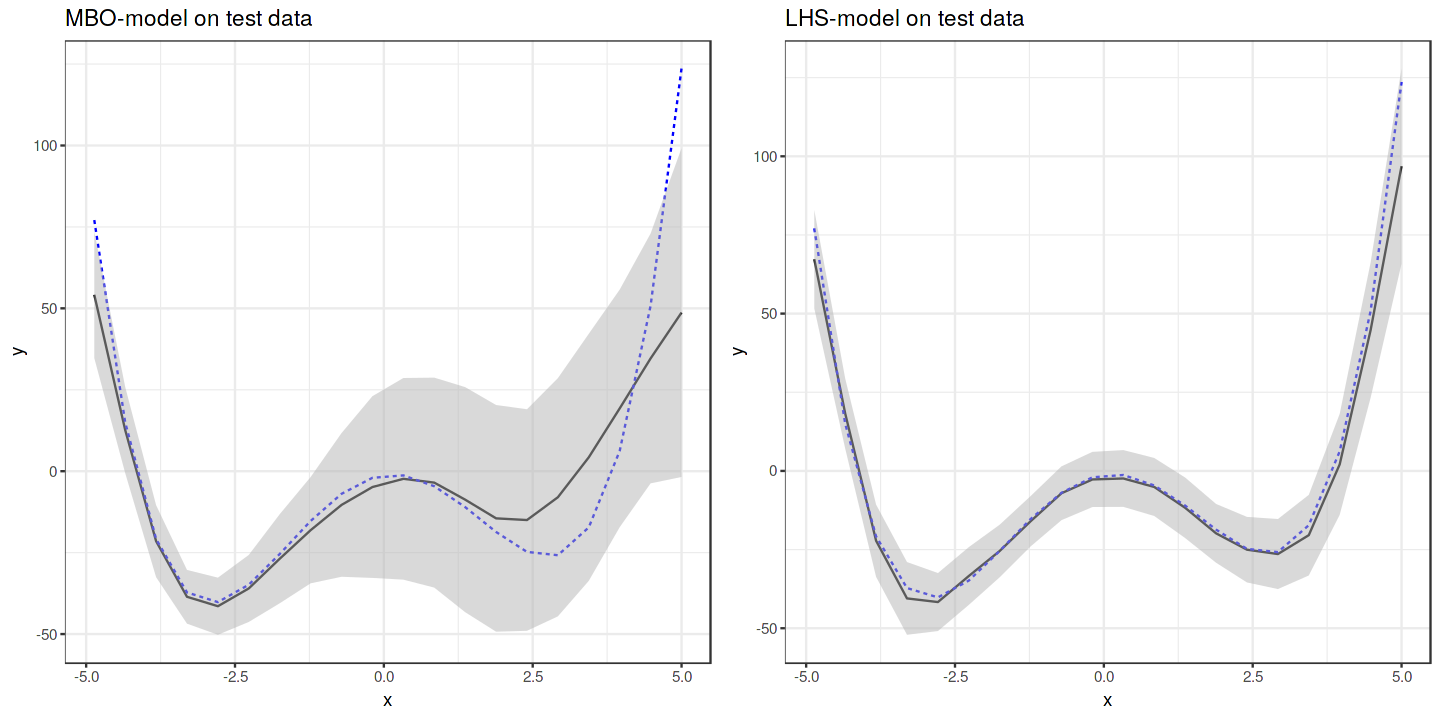

In [187]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("MBO-model on test data") 
p2 = plotPDP(obj1, "LHS", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("LHS-model on test data") 
grid.arrange(p1, p2, ncol = 2)

In [188]:
options(repr.plot.width = 8, repr.plot.height = 6)

preds = setDT(preds)

example_ice_curves = data.frame(y = c(2.5, -1), type = c("ice_curve_1", "ice_curve_2"))

# Explanation
p2 = ggplot() + geom_tile(data = preds[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 = p2 + geom_hline(data = example_ice_curves, aes(yintercept = y, colour = type))

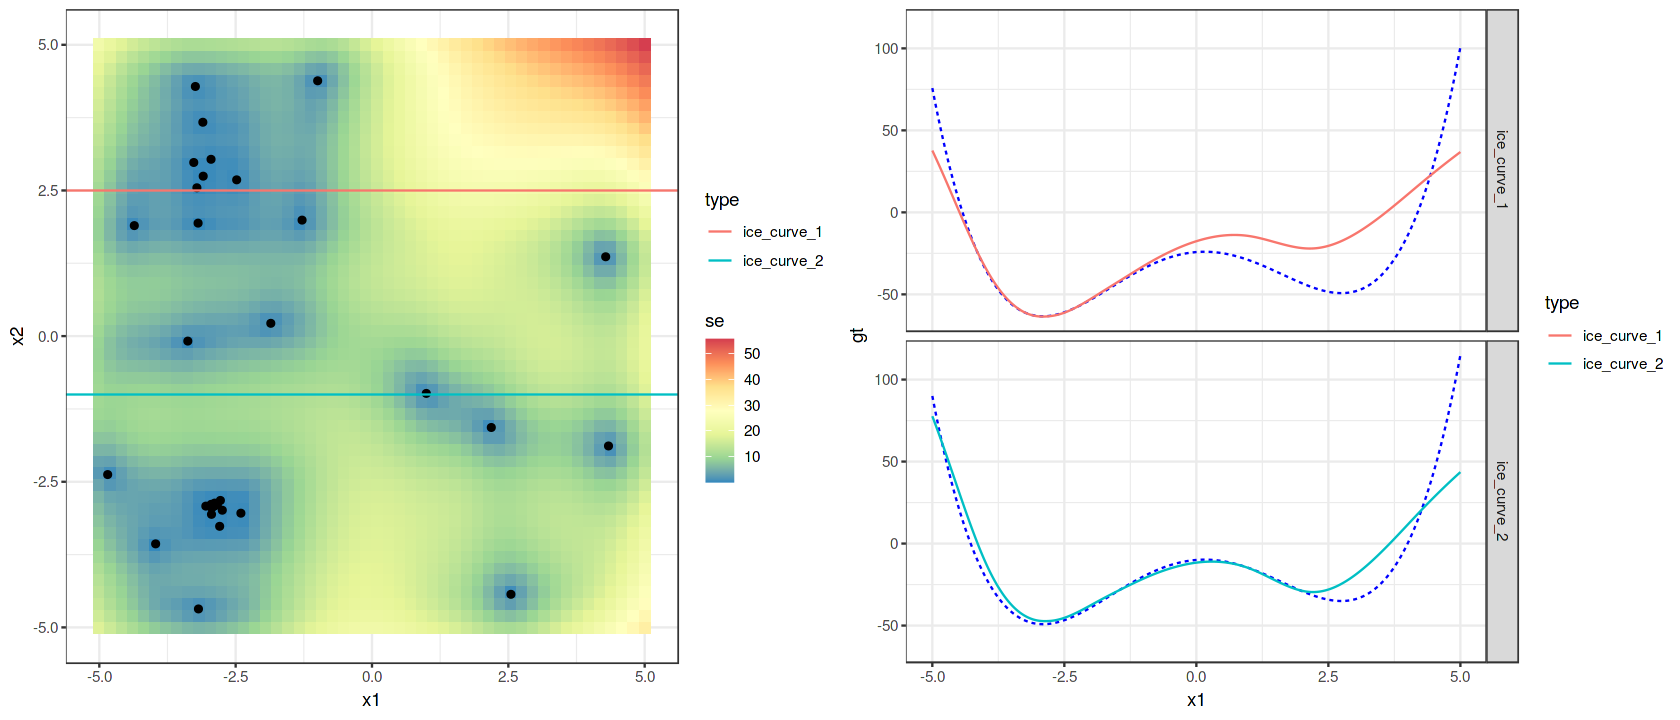

In [189]:
options(repr.plot.width = 14, repr.plot.height = 6)

x1 = seq(-5, 5, by = 0.01)
df_ice = data.frame(x1 = x1, x2 = example_ice_curves$y[1], type = "ice_curve_1")
df_ice = rbind(df_ice, data.frame(x1 = x1, x2 = example_ice_curves$y[2], type = "ice_curve_2"))
pred = predict(models[["lambda1"]], newdata = df_ice[, c("x1", "x2")])
df_ice$response = pred$data$response
df_ice$se = pred$data$se
df_ice$gt = apply(df_ice[, c("x1", "x2")], 1, obj1)

p1 = ggplot() 
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

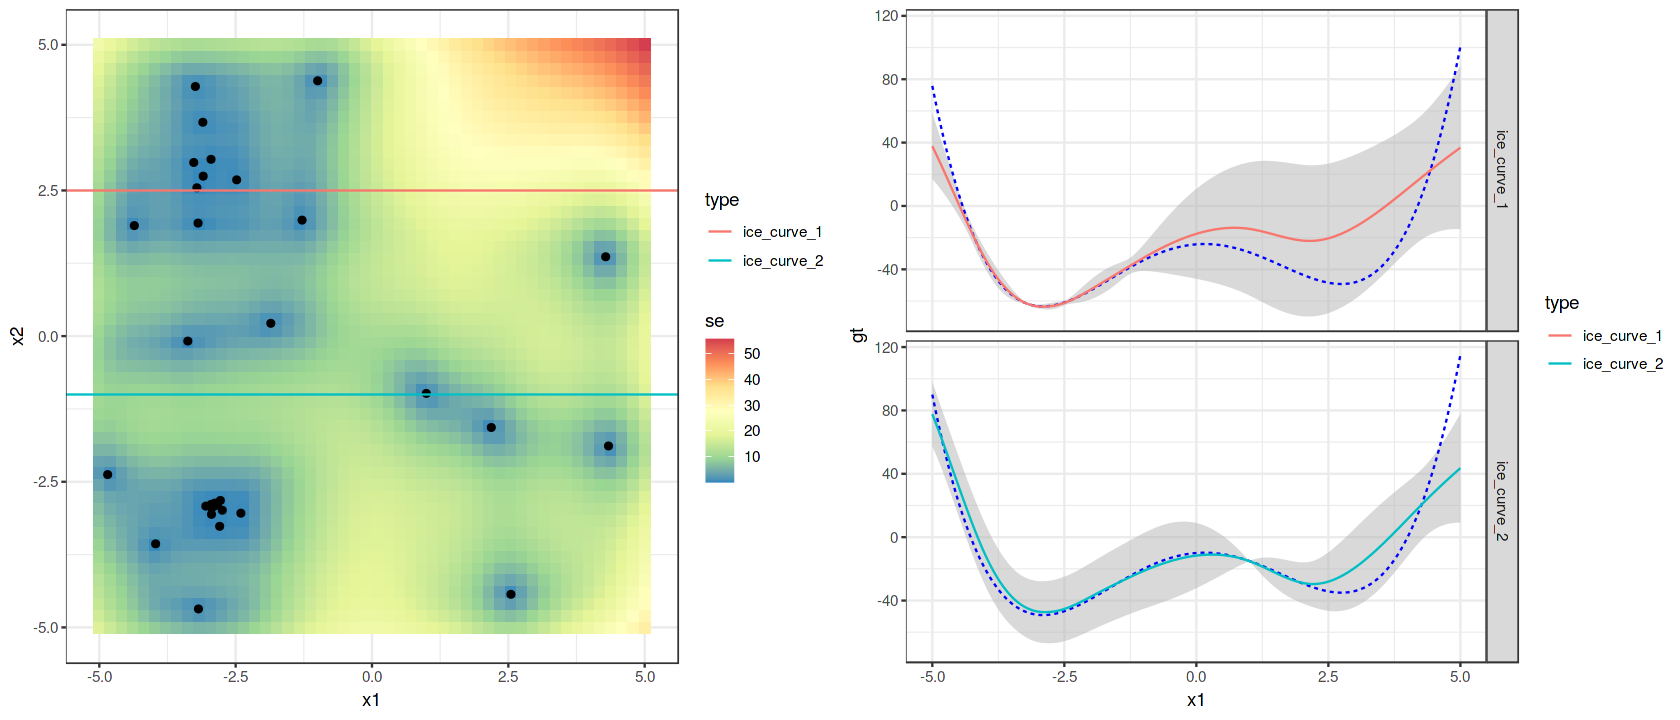

In [37]:
p1 = ggplot()
p1 = p1 + geom_ribbon(data = df_ice, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), fill = "grey70", alpha = 0.5)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)